In [2]:
import pickle 
import random
import itertools
import dataclasses

import numpy as np
from scipy import optimize

from matplotlib import pyplot as plt, rcParams, patches as mplPatches
from matplotlib.axes import Axes as mplAxes

rcParams["font.size"] = 8
rcParams["font.family"] = "Roboto Condensed"

from idpp.db.util import IdPPdb
from idpp.probability.trees import (
    DatasetQueries,
    construct_mz_trees,
    construct_ccs_tree,
    construct_rt_tree,
    construct_ms2_tree_for_adduct_ids,
    load_tree
)

# Constants

In [3]:
# search tolerances
MZ_PPMS = [0.6, 1.0, 1.8, 3.2, 5.6, 10.0, 17.8, 31.6]
CCS_PERCENTS = [0.06, 0.10, 0.18, 0.32, 0.56, 1.00, 1.78, 3.16, 5.62]
RT_TOLERANCES = {
    (408,): [0.1, 0.2, 0.4, 0.8, 1.6],      # IDPP RTP
    (186,): [0.2, 0.4, 0.8, 1.6],           # SMRT_METLIN
    (374, 375): [0.08, 0.16, 0.32, 0.64],   # ?
    (366, 367): [0.2, 0.4, 0.8, 1.6],       # ?
    (260, 261): [0.25, 0.5, 1.0, 2.0],      # ?
}
RT_TOLERANCES_EXTRA = {
    (408,): [3.2],
    (186,): [3.2],
    (374, 375): [1.28],
    (366, 367): [3.2],
    (260, 261): [4.0],
}
MS2_TOLERANCES = [0.99, 0.95, 0.9, 0.8, 0.5, 0.65, 0.25, 0.1]

In [3]:
# queries
MZ_QRY = """--sqlite3
SELECT 
    cmpd_id,
    adduct_mz
FROM 
    Adducts
    JOIN
        Compounds USING(cmpd_id)
WHERE 
    cmpd_id >= 0
    AND adduct_id >= 0
    AND adduct != "none"
    AND adduct_z {}
;"""

RT_QRY = """--sqlite3
SELECT
    cmpd_id,
    rt
FROM 
    RTs
    JOIN
        Adducts USING(adduct_id)
    JOIN
        Compounds USING(cmpd_id)
WHERE
    src_id IN ({})
;"""

CCS_QRY = """--sqlite3
SELECT
    cmpd_id,
    ccs
FROM 
    CCSs
    JOIN
        Adducts USING(adduct_id)
    JOIN
        Compounds USING(cmpd_id)
;"""

MS2_QRY_A = """--sqlite3
SELECT 
    adduct_id,
    COUNT(*) AS cnt 
FROM 
    MS2Spectra 
    JOIN 
        Adducts USING(adduct_id)
GROUP BY 
    adduct_id
;"""

MS2_QRY_B = """--sqlite3
SELECT 
    cmpd_id, 
    adduct_id,
	frag_imz, 
	SUM(frag_ii)
FROM 
    MS2Spectra 
    JOIN 
        Adducts USING(adduct_id)
    JOIN
        Compounds USING(cmpd_id)
	JOIN
		MS2Fragments USING(ms2_id)
GROUP BY 
    adduct_id, 
	frag_imz
;"""

QUERIES = DatasetQueries(
    mz_qry=(MZ_QRY.format("> 0"), MZ_QRY.format("< 0")),
    rt_qry=RT_QRY,
    ccs_qry=CCS_QRY,
    ms2_qry=(MS2_QRY_A, MS2_QRY_B)
)

# Functions

In [6]:
def fexp(x, beta, mu):
    return (1. / beta) * np.exp(-(x - mu) / beta)

def flin(x, a, b):
    return x * a + b

def fpow(x, a, b, c):
    return a * x**b + c

# m/z

## Initialize and Cache

In [5]:
db = IdPPdb("idpp_cleaned_expanded.db", read_only=True, enforce_idpp_ver=False)
mzt_pos, mzt_neg = construct_mz_trees(db, QUERIES)
print("constructed m/z tree")

print("performing m/z only queries")
mz_results = {}
mz_only_probs = {}
for ppm in MZ_PPMS: 
    print(f"{ppm=}")
    # add the results from the positive mode tree directly
    mz_results[ppm] = mzt_pos.query_all(ppm)
    # compute a separate set of results from negative mode then add them
    neg_results = mzt_neg.query_all(ppm)
    for id_neg, matches_neg in neg_results.items():
        if id_neg in mz_results[ppm]:
            mz_results[ppm][id_neg] |= matches_neg
        else:
            mz_results[ppm][id_neg] = matches_neg
    # cache results after each PPM
    with open("_cache/mz_results.pkl", "wb") as pf:
        pickle.dump(mz_results, pf)
    # get the counts
    mz_only_probs[ppm] = [len(v) for v in mz_results[ppm].values()]
    with open("_cache/mz_only_probs.pkl", "wb") as pf:
        pickle.dump(mz_only_probs, pf)

# pre-map compoud IDs to lists of adduct IDs to reduce redundant queries
cmpd_id_to_adduct_id = {
    cmpd_id: [
        adduct_id for adduct_id in db.fetch_adduct_id_by_cmpd_id(cmpd_id)
    ]
    for cmpd_id in set(
        itertools.chain.from_iterable(
            [
                mz_results[ppm].keys() 
                for ppm in MZ_PPMS
            ]
        )
    )
}
print("created compound to adduct id map")

with open("_cache/cmpd_id_to_adduct_id.pkl", "wb") as pf:
    pickle.dump(cmpd_id_to_adduct_id, pf)
print("cached compound to adduct id map")

db.close()

constructed m/z tree
performing m/z only queries
ppm=0.6
ppm=1.0
ppm=1.8
ppm=3.2
ppm=5.6
ppm=10.0
ppm=17.8
ppm=31.6
created compound to adduct id map
cached compound to adduct id map


## Load Cached

In [8]:
with open("_cache/mz_results.pkl", "rb") as pf:
    mz_results = pickle.load(pf)

with open("_cache/mz_only_probs.pkl", "rb") as pf:
    mz_only_probs = pickle.load(pf)

with open("_cache/cmpd_id_to_adduct_id.pkl", "rb") as pf:
    cmpd_id_to_adduct_id = pickle.load(pf)

## Plots

ppm=0.6


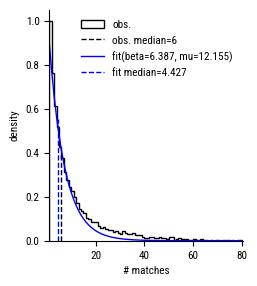

ppm=1.0


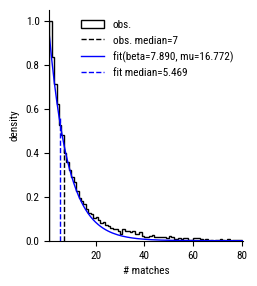

ppm=1.8


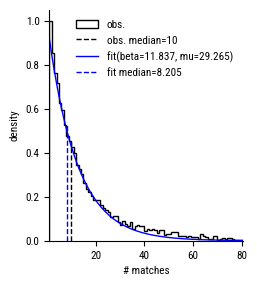

ppm=3.2


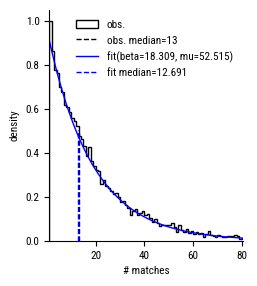

ppm=5.6


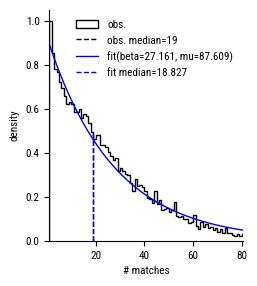

ppm=10.0


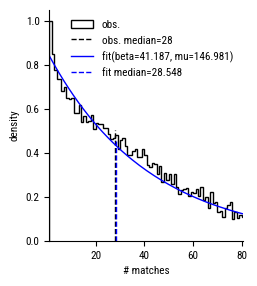

ppm=17.8


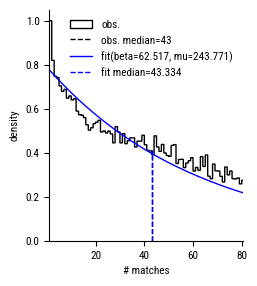

ppm=31.6


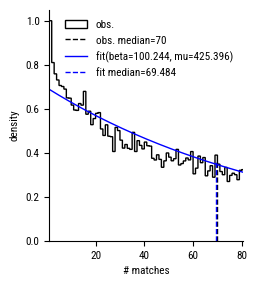

In [9]:
betas, mus, obs_meds = [], [], []
for ppm in MZ_PPMS:
    print(f"{ppm=}")
    fig, ax = plt.subplots(figsize=(2.5, 3))
    bin_max = max(mz_only_probs[ppm]) + 1
    c, x = np.histogram(mz_only_probs[ppm], np.arange(1, bin_max))
    cn = c / max(c)
    ax.hist(mz_only_probs[ppm], bins=np.arange(1, bin_max), color="k", histtype="step", lw=1., 
            weights=[1 / max(c)] * len(mz_only_probs[ppm]), label="obs.")
    obs_med = np.median(mz_only_probs[ppm])
    obs_med_y = cn[np.argmin(np.abs(x - obs_med))]
    ax.axvline(obs_med, ymax=obs_med_y, ls="--", lw=1., label=f"obs. median={obs_med:.0f}", c="k")
    (beta, mu), _ = optimize.curve_fit(fexp, x[:-1], cn)
    ax.plot(x[:-1], fexp(x[:-1], beta, mu), 'b-', lw=1., label=f"fit({beta=:.3f}, {mu=:.3f})")
    fit_med = beta * np.log(2.)
    ax.axvline(fit_med, ymax=fexp(fit_med, beta, mu), ls="--", lw=1., label=f"fit median={fit_med:.3f}", c="b")
    ax.legend(frameon=False)
    for d in ["top", "right"]:
        ax.spines[d].set_visible(False)
    #ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.set_xlabel("# matches")
    ax.set_ylabel("density")
    ax.set_xlim([1, 80 + 0.5])
    plt.savefig(f"_figures/mz/{ppm=}_dist_with_fit.png", dpi=400, bbox_inches="tight")
    plt.show()
    plt.close()
    betas.append(beta)
    mus.append(mu)
    obs_meds.append(obs_med)
fit_meds = [_ * np.log(2) for _ in betas]

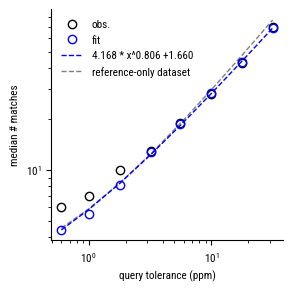

In [10]:
fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(MZ_PPMS, obs_meds, "ko", fillstyle="none", label="obs.")
p, _ = optimize.curve_fit(fpow, MZ_PPMS, obs_meds)
#plt.plot(MZ_PPMS, flin(np.array(MZ_PPMS), *p), "k--", lw=1., label=f"power(a={p[0]:.3f}, b={p[1]:.3f})")
plt.plot(MZ_PPMS, fit_meds, "bo", fillstyle="none", label="fit")
p, _ = optimize.curve_fit(fpow, MZ_PPMS, fit_meds)
plt.plot(MZ_PPMS, fpow(np.array(MZ_PPMS), *p), "b--", lw=1., label=f"{p[0]:.3f} * x^{p[1]:.3f} {p[2]:+.3f}")
plt.plot(MZ_PPMS, fpow(np.array(MZ_PPMS), 3.762, 0.867, 2.117), ls="--", c="grey", lw=1., label=f"reference-only dataset", zorder=-1)
ax.legend(frameon=False)
ax.set_xscale("log")
ax.set_yscale("log")
for d in ["top", "right"]:
    ax.spines[d].set_visible(False)
ax.set_xlabel("query tolerance (ppm)")
ax.set_ylabel("median # matches")
plt.savefig("_figures/mz/medians_obs_fit_vs_tol.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

# m/z + CCS

## Initialize and Cache

In [7]:
db = IdPPdb("idpp_cleaned_expanded.db", read_only=True, enforce_idpp_ver=False)
ccst = construct_ccs_tree(db, QUERIES)

mz_ccs_probs = {}
for ppm in MZ_PPMS:
    for percent in CCS_PERCENTS:
        counts = []
        for id_A, matched_A in mz_results[ppm].items():
            # id_A is a compound ID, need to convert to adduct ID(s) then use that(those)
            # to fetch CCS values to query the CcsTree with
            # treat each set of adduct CCS values as a separate addition to the counts list
            for add_id_A in cmpd_id_to_adduct_id[id_A]:
                # fetch CCS values (if any) then average them and query
                if len(ccss := [_[1] for _ in db.fetch_ccs_by_adduct_id(add_id_A)]) > 0:
                    matched_B = ccst.query_radius_single(np.mean(ccss), percent)
                    counts.append(len(matched_A & matched_B))
        if len(counts) > 0:
            mz_ccs_probs[(ppm, percent)] = counts
print("created m/z + CCS query results")

with open("_cache/mz_ccs_probs.pkl", "wb") as pf:
    pickle.dump(mz_ccs_probs, pf)
print("cached m/z + CCS query results")

db.close()

constructing property trees ...
    CcsTree ... ok
created m/z + CCS query results
cached m/z + CCS query results


## Load Cached

In [ ]:
with open("_cache/mz_ccs_probs.pkl", "rb") as pf:
    mz_ccs_probs = pickle.load(pf)

## Plots

In [ ]:
# keep track of fit parameters and summary stats
ppms, percents = [], []
betas, mus, obs_meds = [], [], []
for ppm in MZ_PPMS:
    for percent in CCS_PERCENTS:
        ppms.append(ppm)
        percents.append(percent)
        print(f"{ppm=} {percent=}")
        fig, ax = plt.subplots(figsize=(2.5, 3))
        bin_max = max(mz_ccs_probs[(ppm, percent)]) + 1
        c, x = np.histogram(mz_ccs_probs[(ppm, percent)], np.arange(1, bin_max))
        cn = c / max(c)
        ax.hist(mz_ccs_probs[(ppm, percent)], bins=np.arange(1, bin_max), color="k", histtype="step", lw=1., 
                weights=[1 / max(c)] * len(mz_ccs_probs[(ppm, percent)]), label="obs.") 
        obs_med = np.median(mz_ccs_probs[(ppm, percent)])
        ax.axvline(obs_med, ls="--", lw=1., label=f"obs. median={obs_med:.0f}", c="k")
        (beta, mu), _ = optimize.curve_fit(fexp, x[:-1], cn)
        ax.plot(x[:-1], fexp(x[:-1], beta, mu), 'b-', lw=1., label=f"fit({beta=:.3f}, {mu=:.3f})")
        fit_med = beta * np.log(2.)
        ax.axvline(fit_med, ls="--", lw=1., label=f"fit median={fit_med:.3f}", c="b")
        ax.legend(frameon=False)
        for d in ["top", "right"]:
            ax.spines[d].set_visible(False)
        #ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        ax.set_xlabel("# matches")
        ax.set_ylabel("density")
        ax.set_xlim([1, 80 + 0.5])
        plt.savefig(f"_figures/mz_ccs/{ppm=}_{percent=}_dist_with_fit.png", dpi=400, bbox_inches="tight")
        plt.show()
        plt.close()
        betas.append(beta)
        mus.append(mu)
        obs_meds.append(obs_med)
fit_meds = [_ * np.log(2) for _ in betas]

In [ ]:
fig, (ax, axcb) = plt.subplots(ncols=2, width_ratios=(9, 1), figsize=(5, 4.5))
mz_bins = MZ_PPMS + [56]
ccs_bins = CCS_PERCENTS + [10]
levels = [_ for _ in range(11)] + [15, 20, 25, 30, 40, 50]
tcf = ax.tricontourf(ppms, percents, fit_meds, levels, cmap="binary_r", norm="log")
ax.tricontour(ppms, percents, fit_meds, levels, colors="k", linewidths=0.5)
ax.plot(ppms, percents, "wo", ms=5, fillstyle="none", mew=0.5, alpha=0.2)
ax.set_xlabel("m/z tolerance (ppm)")
ax.set_ylabel("CCS tolerance (%)")
ax.set_xscale("log")
ax.set_yscale("log")
cb = fig.colorbar(tcf, cax=axcb)
cb.set_ticks(levels[1:])
cb.set_ticklabels(levels[1:])
for l in levels[1:-1]:
    cb.ax.axhline(l, lw=0.75, c="k")
cb.set_label("median # matches (fit)")
plt.savefig("_figures/mz_ccs/2D_tolerance_contour.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

# m/z + RT

## Initialize and Cache

In [12]:
db = IdPPdb("idpp_cleaned_expanded.db", read_only=True, enforce_idpp_ver=False)

In [13]:
for src_ids in RT_TOLERANCES.keys():
    qrs = dataclasses.replace(QUERIES)
    qrs.rt_qry = qrs.rt_qry.format(",".join([str(_) for _ in src_ids]))
    rtt = construct_rt_tree(db, qrs)
    rtt.save("_cache", ".".join([str(_) for _ in src_ids]))

constructing property trees ...
    RtTree ... ok
constructing property trees ...
    RtTree ... ok
constructing property trees ...
    RtTree ... ok
constructing property trees ...
    RtTree ... ok
constructing property trees ...
    RtTree ... ok


In [14]:
# load pre-made RT trees
rtt = {
    src_ids: load_tree(f"_cache/RtTree_dsid={".".join([str(_) for _ in src_ids])}.pkl")
    for src_ids in RT_TOLERANCES.keys()
}

In [15]:
mz_rt = {}

In [16]:
for i in range(3):
    random.seed(i + 100)
    for ppm in MZ_PPMS:
        print(f"{ppm=}")
        selected = 0
        for i, (id_A, matched_A) in enumerate(mz_results[ppm].items()):
            if random.random() > 0.1:  # sample 10%
                # most of the time just skip
                continue
            selected += 1
            try:
                # id_A is a compound ID
                # because this is RT and it does not really matter what the adduct is, search directly using the 
                # compound ID
                # treat each set of adduct RT values as a separate addition to the counts list
                #print(f"{id_A=} {matched_A=}")
                for src_ids, tols in RT_TOLERANCES.items():
                    #print(f"{src_ids=}")
                    for (_, rt) in db.fetch_rt_by_cmpd_id(id_A, select_sources=list(src_ids)):
                        #print(f"rt_id={_} {rt=:.2f}")
                        for tol in tols:
                            matched_B = rtt[src_ids].query_radius_single(rt, tol)
                            common = matched_A & matched_B
                            n = len(common)
                            k = (ppm, tol)
                            k += src_ids
                            if k in mz_rt:
                                mz_rt[k].append(n)
                            else:
                                mz_rt[k] = [n]
                print(f"\rsampled {selected} of {i + 1}  ({100 * (selected / (i + 1)):.1f} %)", end="    ")
            except KeyboardInterrupt:
                break
            except Exception as e:
                print("Exception:", e)
                continue
            #print("---")
        print()
        # cache the results after each ppm completes
        with open("_cache/mz_rt.pkl", "wb") as pf:
            pickle.dump(mz_rt, pf)
    print()

ppm=0.6
sampled 19754 of 198888  (9.9 %)     
ppm=1.0
sampled 19773 of 198869  (9.9 %)     
ppm=1.8
sampled 19870 of 198893  (10.0 %)    
ppm=3.2
sampled 19905 of 198867  (10.0 %)    
ppm=5.6
sampled 19741 of 198885  (9.9 %)     
ppm=10.0
sampled 19908 of 198873  (10.0 %)    
ppm=17.8
sampled 19843 of 198878  (10.0 %)    
ppm=31.6
sampled 19732 of 198883  (9.9 %)    

ppm=0.6
sampled 19924 of 198891  (10.0 %)    
ppm=1.0
sampled 19861 of 198888  (10.0 %)    
ppm=1.8
sampled 19893 of 198886  (10.0 %)    
ppm=3.2
sampled 20025 of 198895  (10.1 %)    
ppm=5.6
sampled 20033 of 198882  (10.1 %)    
ppm=10.0
sampled 20058 of 198896  (10.1 %)    
ppm=17.8
sampled 19797 of 198882  (10.0 %)    
ppm=31.6
sampled 19754 of 198895  (9.9 %)     

ppm=0.6
sampled 19827 of 198886  (10.0 %)    
ppm=1.0
sampled 19835 of 198883  (10.0 %)    
ppm=1.8
sampled 20036 of 198892  (10.1 %)    
ppm=3.2
sampled 19884 of 198863  (10.0 %)    
ppm=5.6
sampled 19851 of 198889  (10.0 %)    
ppm=10.0
sampled 19890 of 1

In [17]:
db.close()

## Load Cached

In [ ]:
with open("_cache/mz_rt.pkl", "rb") as pf:
    mz_rt_probs = pickle.load(pf)

## Plots

In [18]:
# unpack and combine the mz rt query results
mz_rt_probs = {
    src_ids: {}
    for src_ids in RT_TOLERANCES.keys()
}
for (ppm, tol, *src_ids), counts  in mz_rt.items():
    mz_rt_probs[tuple(src_ids)][(ppm, tol)] = counts

src_ids=(408,)
ppm=0.6 tol=0.1
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[1.00000000e+00 2.34099943e-01 8.53208404e-02 4.65644520e-02
 2.69733106e-02 1.49063032e-02 1.13571834e-02 7.38216922e-03
 4.82680295e-03 1.41964793e-02 5.67859171e-03 2.12947189e-03
 1.98750710e-03 2.41340148e-03 2.27143668e-03 1.27768313e-03
 1.27768313e-03 2.83929585e-04 8.51788756e-04 1.41964793e-03]


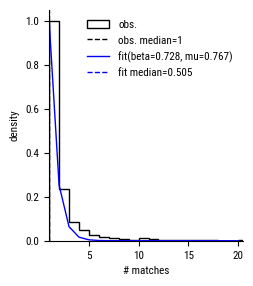

ppm=0.6 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[1.00000000e+00 2.85154336e-01 1.22978932e-01 7.25134738e-02
 5.04654581e-02 3.46235505e-02 2.30279275e-02 2.15580598e-02
 1.19222603e-02 1.91082803e-02 1.04523926e-02 8.49256900e-03
 2.93973542e-03 3.42969133e-03 2.28646089e-03 2.12314225e-03
 1.63318635e-03 3.10305406e-03 1.95982362e-03 3.75632860e-03
 2.44977952e-03 6.53274539e-04 4.89955904e-04 4.89955904e-04]


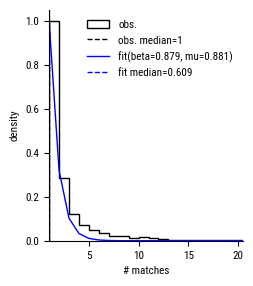

ppm=0.6 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[1.00000000e+00 3.46554094e-01 1.74356961e-01 1.17219713e-01
 8.14843903e-02 6.12605537e-02 3.84841940e-02 3.04339289e-02
 2.57215786e-02 3.29864520e-02 1.98311408e-02 1.45297467e-02
 1.11918319e-02 9.03200471e-03 6.87217750e-03 7.46122128e-03
 4.71235028e-03 7.06852543e-03 6.67582957e-03 5.10504614e-03
 5.30139407e-03 3.14156686e-03 4.31965443e-03 1.37443550e-03
 5.89043786e-04 5.89043786e-04 1.57078343e-03 2.15982721e-03
 1.57078343e-03 1.17808757e-03 1.76713136e-03 9.81739643e-04
 1.96347929e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.92695857e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.96347929e-04 1.96347929e-04]


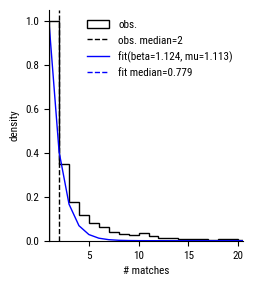

ppm=0.6 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56]
[1.00000000e+00 3.90532544e-01 2.20118343e-01 1.66863905e-01
 1.16686391e-01 8.26035503e-02 6.69822485e-02 5.01775148e-02
 3.69230769e-02 4.40236686e-02 3.62130178e-02 2.81656805e-02
 2.22485207e-02 1.77514793e-02 1.91715976e-02 1.58579882e-02
 1.51479290e-02 1.23076923e-02 9.70414201e-03 9.23076923e-03
 8.75739645e-03 9.23076923e-03 8.28402367e-03 4.73372781e-03
 4.49704142e-03 2.84023669e-03 2.13017751e-03 8.75739645e-03
 6.62721893e-03 2.36686391e-03 5.44378698e-03 1.42011834e-03
 3.07692308e-03 7.10059172e-04 9.46745562e-04 9.46745562e-04
 2.36686391e-04 4.73372781e-04 0.00000000e+00 1.18343195e-03
 1.42011834e-03 9.46745562e-04 2.36686391e-04 9.46745562e-04
 7.10059172e-04 1.42011834e-03 2.36686391e-04 9.46745562e-04
 9.46745562e-04 4.73372781e-04 0.00000000e+00 4.73372781e-04
 2.36686391e-04 2.3

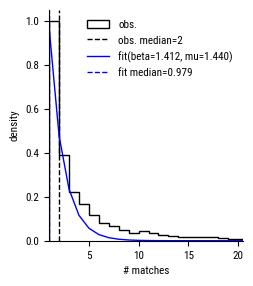

ppm=0.6 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76]
[1.00000000e+00 4.30590191e-01 2.48545303e-01 2.09476309e-01
 1.42975894e-01 1.06400665e-01 8.34026046e-02 8.14630091e-02
 5.12607370e-02 6.28983098e-02 5.45857578e-02 4.26711000e-02
 3.82377390e-02 2.68772513e-02 2.21668052e-02 2.35522305e-02
 2.18897201e-02 1.71792740e-02 1.49625935e-02 1.91188695e-02
 1.24688279e-02 1.49625935e-02 1.52396786e-02 7.20421169e-03
 1.13604877e-02 7.20421169e-03 8.86672208e-03 1.19146578e-02
 7.75838182e-03 6.37295650e-03 9.14380715e-03 5.54170130e-03
 6.37295650e-03 1.93959546e-03 1.10834026e-03 1.10834026e-03
 5.54170130e-04 5.54170130e-04 1.38542533e-03 1.10834026e-03
 2.21668052e-03 1.66251039e-03 0.00000000e+00 1.66251039e-03
 5.54170130e-04 2.21668052e-03 2.77085065e-04 1.10834026e-03
 5.54170130e-04 4.7

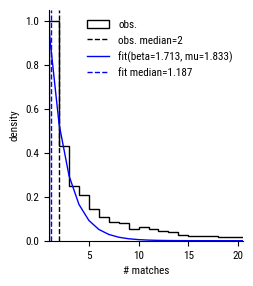

ppm=1.0 tol=0.1
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[1.00000000e+00 2.34140877e-01 8.55622462e-02 4.45315782e-02
 2.38061896e-02 1.42837138e-02 1.24632404e-02 7.14185688e-03
 3.50091024e-03 1.28833497e-02 5.18134715e-03 2.10054614e-03
 1.54040050e-03 1.54040050e-03 1.12029128e-03 1.12029128e-03
 8.40218457e-04 5.60145638e-04 8.40218457e-04 1.40036409e-04]


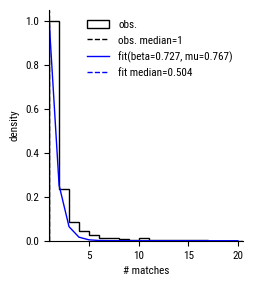

ppm=1.0 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[1.         0.28635634 0.12006421 0.0776886  0.04494382 0.0329053
 0.01894061 0.01573034 0.01155698 0.01797753 0.01364366 0.00642055
 0.00272873 0.00160514 0.00176565 0.00144462 0.00144462 0.00401284
 0.00176565 0.00256822 0.0011236  0.0011236 ]


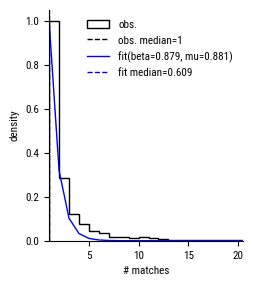

ppm=1.0 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[1.00000000e+00 3.43075454e-01 1.66189112e-01 1.05062082e-01
 8.46227316e-02 5.69245463e-02 4.16427889e-02 2.42597899e-02
 2.38777459e-02 2.50238777e-02 1.62368672e-02 1.62368672e-02
 1.06972302e-02 7.83190067e-03 7.25883477e-03 7.25883477e-03
 6.68576886e-03 5.15759312e-03 6.11270296e-03 6.49474690e-03
 4.20248329e-03 1.14613181e-03 1.71919771e-03 2.10124164e-03
 7.64087870e-04 0.00000000e+00 2.67430755e-03 1.52817574e-03
 5.73065903e-04 1.14613181e-03 1.91021968e-03 7.64087870e-04
 3.82043935e-04 1.52817574e-03 0.00000000e+00 0.00000000e+00
 1.91021968e-04 0.00000000e+00 0.00000000e+00 1.91021968e-04
 1.91021968e-04 7.64087870e-04]


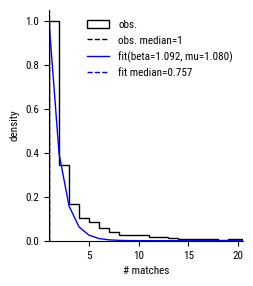

ppm=1.0 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]
[1.00000000e+00 3.86757991e-01 2.15981735e-01 1.56849315e-01
 1.01141553e-01 7.48858447e-02 6.91780822e-02 4.49771689e-02
 3.99543379e-02 3.94977169e-02 3.67579909e-02 2.48858447e-02
 1.87214612e-02 1.82648402e-02 1.55251142e-02 1.21004566e-02
 1.07305936e-02 8.44748858e-03 6.84931507e-03 1.02739726e-02
 6.84931507e-03 9.13242009e-03 7.53424658e-03 5.93607306e-03
 4.10958904e-03 2.51141553e-03 2.28310502e-03 4.10958904e-03
 4.79452055e-03 1.59817352e-03 6.16438356e-03 1.14155251e-03
 2.51141553e-03 1.59817352e-03 2.28310502e-04 1.36986301e-03
 2.28310502e-04 9.13242009e-04 4.56621005e-04 1.36986301e-03
 9.13242009e-04 1.82648402e-03 4.56621005e-04 6.84931507e-04
 9.13242009e-04 1.14155251e-03 9.13242009e-04 2.05479452e-03
 1.82648402e-03 1.36986301e-03 0.00000000e+00 2.28310502e-04
 0.00000000e+00 4.5662100

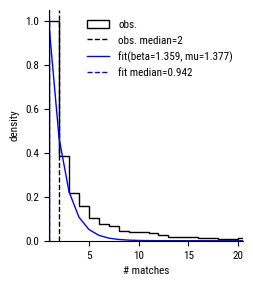

ppm=1.0 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76]
[1.00000000e+00 4.19647624e-01 2.50934330e-01 1.99679658e-01
 1.29738388e-01 1.08115323e-01 7.90176188e-02 7.42124933e-02
 5.41911372e-02 6.19327282e-02 4.88521089e-02 3.41697811e-02
 3.68392952e-02 2.93646556e-02 2.45595302e-02 2.40256273e-02
 1.86865990e-02 1.33475707e-02 1.17458623e-02 1.30806193e-02
 1.01441538e-02 1.57501335e-02 9.61025093e-03 5.33902830e-03
 9.61025093e-03 4.27122264e-03 4.27122264e-03 6.40683396e-03
 6.67378537e-03 6.13988254e-03 9.07634810e-03 5.07207688e-03
 4.53817405e-03 1.33475707e-03 1.33475707e-03 1.33475707e-03
 1.33475707e-03 1.33475707e-03 1.06780566e-03 8.00854245e-04
 1.06780566e-03 1.33475707e-03 1.06780566e-03 1.86865990e-03
 5.33902830e-04 8.00854245e-04 0.00000000e+00 8.00854245e-04
 8.00854245e-04 5.3

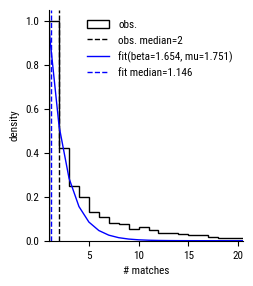

ppm=1.8 tol=0.1
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[1.00000000e+00 2.42649118e-01 9.08709045e-02 4.56454775e-02
 2.74432932e-02 1.68020162e-02 1.24614954e-02 8.40100812e-03
 3.08036964e-03 1.40016802e-02 5.46065528e-03 1.26015122e-03
 1.96023523e-03 1.54018482e-03 1.68020162e-03 9.80117614e-04
 1.68020162e-03 9.80117614e-04 5.60067208e-04 9.80117614e-04]


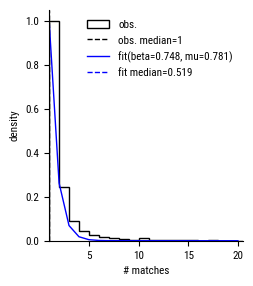

ppm=1.8 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[1.00000000e+00 3.02829426e-01 1.22392886e-01 7.85772029e-02
 5.18997575e-02 3.57316087e-02 2.23120453e-02 1.64915117e-02
 1.21261116e-02 1.90784155e-02 1.30962005e-02 9.05416330e-03
 3.71867421e-03 3.07194826e-03 2.10185934e-03 1.61681487e-03
 1.29345190e-03 3.71867421e-03 1.45513339e-03 2.58690380e-03
 1.94017785e-03 1.13177041e-03 6.46725950e-04 3.23362975e-04]


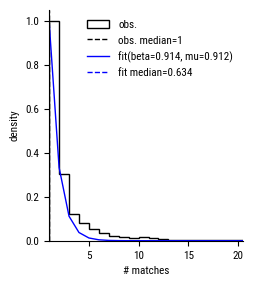

ppm=1.8 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
[1.00000000e+00 3.73385519e-01 1.80626223e-01 1.12328767e-01
 8.49315068e-02 6.02739726e-02 4.40313112e-02 3.03326810e-02
 2.81800391e-02 2.93542074e-02 2.03522505e-02 1.52641879e-02
 1.23287671e-02 1.05675147e-02 6.26223092e-03 7.43639922e-03
 5.87084149e-03 6.26223092e-03 5.87084149e-03 7.04500978e-03
 5.28375734e-03 2.73972603e-03 2.54403131e-03 2.54403131e-03
 1.36986301e-03 3.91389432e-04 1.17416830e-03 2.15264188e-03
 1.17416830e-03 1.76125245e-03 1.56555773e-03 5.87084149e-04
 1.95694716e-04 5.87084149e-04 0.00000000e+00 0.00000000e+00
 1.95694716e-04 1.95694716e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.78473581e-04 0.00000000e+00 1.95694716e-04]


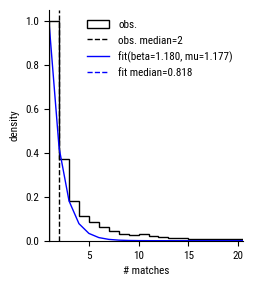

ppm=1.8 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55]
[1.00000000e+00 4.26456543e-01 2.40210124e-01 1.58070678e-01
 1.23447947e-01 8.90639924e-02 7.21107927e-02 4.39350525e-02
 4.13085005e-02 5.63514804e-02 3.77268386e-02 2.79369628e-02
 1.88634193e-02 2.05348615e-02 1.74307545e-02 1.93409742e-02
 1.28939828e-02 8.83476600e-03 7.64087870e-03 8.83476600e-03
 8.11843362e-03 1.09837631e-02 8.35721108e-03 6.92454632e-03
 5.49188157e-03 3.34288443e-03 2.38777459e-03 8.35721108e-03
 5.25310411e-03 1.67144222e-03 7.64087870e-03 1.19388730e-03
 2.62655205e-03 2.38777459e-04 1.91021968e-03 1.43266476e-03
 2.38777459e-04 9.55109838e-04 1.19388730e-03 7.16332378e-04
 2.38777459e-04 2.14899713e-03 4.77554919e-04 7.16332378e-04
 9.55109838e-04 1.19388730e-03 9.55109838e-04 1.19388730e-03
 9.55109838e-04 1.19388730e-03 2.38777459e-04 2.38777459e-04
 0.00000000e+00 2.3877

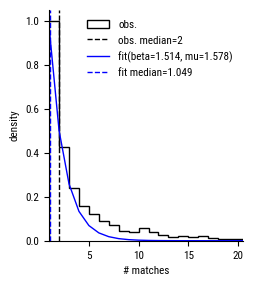

ppm=1.8 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76]
[1.00000000e+00 4.69283276e-01 2.84129693e-01 2.11319681e-01
 1.59271900e-01 1.13196815e-01 9.67007964e-02 7.39476678e-02
 6.08646189e-02 6.91126280e-02 6.25711035e-02 3.61205916e-02
 4.46530148e-02 3.75426621e-02 2.70193402e-02 2.30375427e-02
 2.07622298e-02 1.45051195e-02 1.33674630e-02 1.56427759e-02
 1.39362912e-02 1.42207053e-02 1.30830489e-02 7.39476678e-03
 1.13765643e-02 5.97269625e-03 4.26621160e-03 1.25142207e-02
 6.54152446e-03 7.96359499e-03 1.05233220e-02 6.82593857e-03
 7.11035267e-03 3.41296928e-03 1.70648464e-03 2.27531286e-03
 5.68828214e-04 2.84414107e-04 3.12855518e-03 1.13765643e-03
 1.70648464e-03 1.70648464e-03 1.42207053e-03 8.53242321e-04
 8.53242321e-04 1.13765643e-03 1.13765643e-03 1.42207053e-03
 8.53242321e-04 4.8

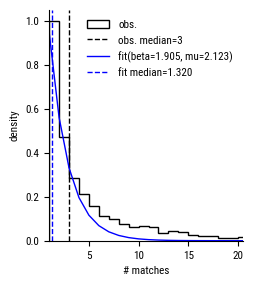

ppm=3.2 tol=0.1
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[1.00000000e+00 2.40069085e-01 9.41278066e-02 4.43293034e-02
 2.96488198e-02 1.58318941e-02 1.29533679e-02 8.05987334e-03
 5.32527346e-03 1.45365573e-02 7.05238918e-03 2.01496834e-03
 2.15889465e-03 2.15889465e-03 2.01496834e-03 1.72711572e-03
 1.58318941e-03 5.75705239e-04 7.19631549e-04 1.15141048e-03]


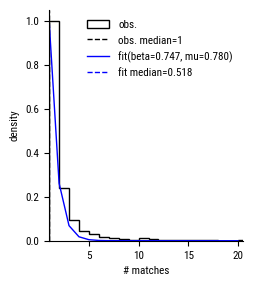

ppm=3.2 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[1.00000000e+00 3.09155167e-01 1.34971390e-01 8.21272299e-02
 5.16661057e-02 3.21440592e-02 2.59171996e-02 1.98586335e-02
 1.21171323e-02 2.17098620e-02 1.22854258e-02 6.05856614e-03
 6.05856614e-03 2.86098957e-03 3.02928307e-03 2.52440256e-03
 2.01952205e-03 2.86098957e-03 2.18781555e-03 3.53416358e-03
 1.34634803e-03 1.85122854e-03 1.17805453e-03 1.68293504e-04]


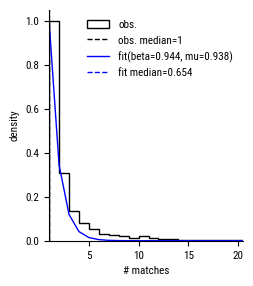

ppm=3.2 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
[1.00000000e+00 4.05018664e-01 1.91206968e-01 1.17586064e-01
 9.24927416e-02 6.05557860e-02 4.23060971e-02 3.64993779e-02
 2.86188304e-02 3.46329324e-02 1.88718374e-02 1.61758606e-02
 1.34798839e-02 1.24429697e-02 4.97718789e-03 7.05101618e-03
 8.50269598e-03 6.22148486e-03 6.84363335e-03 6.22148486e-03
 5.59933637e-03 3.31812526e-03 2.07382829e-03 2.69597677e-03
 2.28121112e-03 1.45167980e-03 1.65906263e-03 2.28121112e-03
 8.29531315e-04 6.22148486e-04 2.69597677e-03 8.29531315e-04
 1.86644546e-03 1.03691414e-03 4.14765657e-04 2.07382829e-04
 0.00000000e+00 6.22148486e-04 0.00000000e+00 0.00000000e+00
 2.07382829e-04 2.07382829e-04 2.07382829e-04 2.07382829e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.07382829e-04]


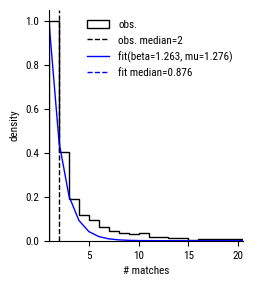

ppm=3.2 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58]
[1.00000000e+00 4.68129032e-01 2.58838710e-01 1.85548387e-01
 1.25161290e-01 9.05806452e-02 8.00000000e-02 5.26451613e-02
 4.90322581e-02 5.85806452e-02 4.41290323e-02 2.65806452e-02
 2.34838710e-02 2.40000000e-02 1.72903226e-02 1.60000000e-02
 1.54838710e-02 1.03225806e-02 9.03225806e-03 1.00645161e-02
 8.00000000e-03 1.21290323e-02 9.54838710e-03 6.19354839e-03
 6.96774194e-03 2.32258065e-03 3.35483871e-03 7.74193548e-03
 5.93548387e-03 1.80645161e-03 8.51612903e-03 2.58064516e-03
 2.58064516e-03 1.03225806e-03 2.32258065e-03 5.16129032e-04
 2.58064516e-04 5.16129032e-04 2.58064516e-04 5.16129032e-04
 1.54838710e-03 5.16129032e-04 2.58064516e-04 1.54838710e-03
 2.58064516e-04 7.74193548e-04 2.58064516e-04 1.29032258e-03
 4.12903226e-03 1.29032258e-03 7.74193548e-04 5.16129032e-04
 2.58064516e-

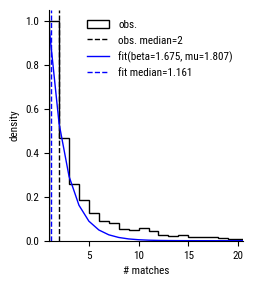

ppm=3.2 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98]
[1.00000000e+00 4.93188854e-01 3.21671827e-01 2.31888545e-01
 1.71517028e-01 1.21671827e-01 1.00619195e-01 8.66873065e-02
 6.71826625e-02 7.30650155e-02 7.27554180e-02 4.11764706e-02
 5.07739938e-02 3.86996904e-02 3.65325077e-02 2.35294118e-02
 2.66253870e-02 1.54798762e-02 1.54798762e-02 1.82662539e-02
 1.82662539e-02 2.13622291e-02 1.42414861e-02 1.20743034e-02
 8.04953560e-03 4.02476780e-03 3.40557276e-03 1.48606811e-02
 7.73993808e-03 4.33436533e-03 1.48606811e-02 5.88235294e-03
 9.28792570e-03 3.40557276e-03 2.47678019e-03 2.16718266e-03
 9.28792570e-04 1.23839009e-03 3.40557276e-03 3.09597523e-04
 1.54798762e-03 1.23839009e-03 2.16718266e-03 0.00000000e+00
 0.00000000e+

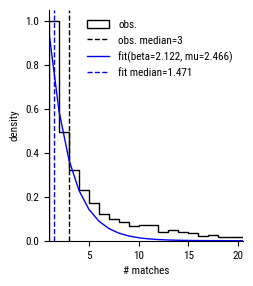

ppm=5.6 tol=0.1
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[1.00000000e+00 2.58949192e-01 9.56986143e-02 4.63337182e-02
 3.21882217e-02 1.68879908e-02 1.53002309e-02 8.94919169e-03
 4.18591224e-03 1.50115473e-02 5.62933025e-03 2.02078522e-03
 1.29907621e-03 2.16512702e-03 1.58775982e-03 1.73210162e-03
 1.73210162e-03 5.77367206e-04 1.73210162e-03 1.01039261e-03]


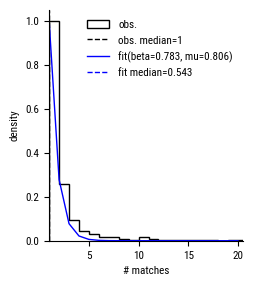

ppm=5.6 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
[1.00000000e+00 3.31463539e-01 1.38704742e-01 8.44807071e-02
 5.79636240e-02 3.73958865e-02 2.44773075e-02 2.37973823e-02
 1.34285229e-02 2.14176441e-02 1.18986911e-02 6.79925208e-03
 5.26942036e-03 3.73958865e-03 3.22964474e-03 2.20975693e-03
 2.54971953e-03 2.03977562e-03 2.54971953e-03 3.05966344e-03
 1.18986911e-03 2.54971953e-03 3.39962604e-04 5.09943906e-04
 1.69981302e-04 1.69981302e-04 0.00000000e+00 3.39962604e-04]


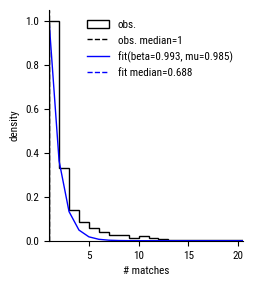

ppm=5.6 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
[1.00000000e+00 4.13641133e-01 2.04616999e-01 1.29066107e-01
 8.94018888e-02 6.61070304e-02 5.43546695e-02 3.54669465e-02
 3.12696747e-02 3.29485834e-02 1.93074502e-02 1.82581322e-02
 1.44805876e-02 1.44805876e-02 8.81427072e-03 8.18467996e-03
 8.60440714e-03 8.18467996e-03 7.13536201e-03 5.03672613e-03
 7.34522560e-03 5.24658972e-03 1.46904512e-03 1.88877230e-03
 1.25918153e-03 1.04931794e-03 1.88877230e-03 1.88877230e-03
 8.39454355e-04 4.19727177e-04 1.25918153e-03 1.46904512e-03
 4.19727177e-04 0.00000000e+00 0.00000000e+00 2.09863589e-04
 2.09863589e-04 2.09863589e-04 2.09863589e-04 6.29590766e-04
 2.09863589e-04 2.09863589e-04 1.04931794e-03 4.19727177e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.19727177e-04
 2.09863589e-04]


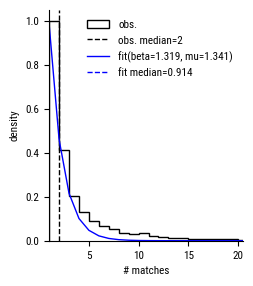

ppm=5.6 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86]
[1.00000000e+00 4.81742306e-01 2.69431403e-01 1.84924361e-01
 1.39540949e-01 9.41575378e-02 7.61606677e-02 6.05112154e-02
 5.08607199e-02 5.47730829e-02 4.35576421e-02 2.99947835e-02
 2.79081899e-02 2.26917058e-02 1.95618153e-02 1.59102765e-02
 1.53886281e-02 1.35628586e-02 1.25195618e-02 1.06937924e-02
 9.91131977e-03 1.35628586e-02 1.22587376e-02 9.65049557e-03
 7.82472613e-03 2.08659364e-03 3.65153886e-03 7.30307773e-03
 7.82472613e-03 5.21648409e-03 5.99895670e-03 2.34741784e-03
 2.86906625e-03 1.56494523e-03 1.04329682e-03 2.08659364e-03
 0.00000000e+00 2.60824204e-04 7.82472613e-04 2.60824204e-04
 7.82472613e-04 5.21648409e-04 7.82472613e-04 1.56494523e-03
 0.00000000e+00 0.00000000e+00 1.04329682e-03 7.82

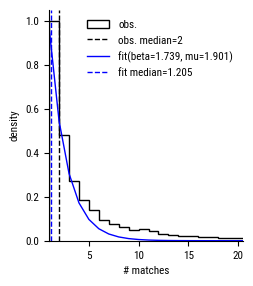

ppm=5.6 tol=1.6
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122]
[1.00000000e+00 5.32945736e-01 3.36563307e-01 2.67118863e-01
 1.74741602e-01 1.33397933e-01 1.22093023e-01 8.78552972e-02
 6.65374677e-02 8.72093023e-02 6.58914729e-02 4.78036176e-02
 5.32945736e-02 3.97286822e-02 3.32687339e-02 3.03617571e-02
 3.19767442e-02 1.64728682e-02 1.61498708e-02 2.29328165e-02
 1.71188630e-02 2.03488372e-02 1.71188630e-02 1.67958656e-02
 1.35658915e-02 7.10594315e-03 7.42894057e-03 1.16279070e-02
 1.58268734e-02 6.45994832e-03 1.19509044e-02 3.87596899e-03


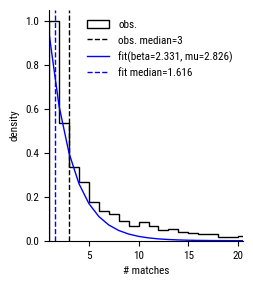

ppm=10.0 tol=0.1
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[1.00000000e+00 2.70479595e-01 1.00983021e-01 4.69168901e-02
 3.05332142e-02 1.69794459e-02 1.20643432e-02 1.11706881e-02
 4.61721775e-03 1.53410783e-02 7.44712541e-03 2.82990766e-03
 1.78731010e-03 2.23413762e-03 2.08519511e-03 1.04259756e-03
 5.95770033e-04 7.44712541e-04 8.93655049e-04 8.93655049e-04]


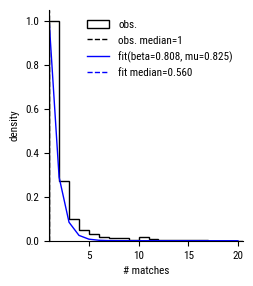

ppm=10.0 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[1.00000000e+00 3.48874313e-01 1.54937068e-01 8.84594930e-02
 5.51320688e-02 3.74047155e-02 2.57046623e-02 2.07410034e-02
 1.54227974e-02 2.34001064e-02 1.22318738e-02 7.80003545e-03
 7.62276192e-03 3.01365006e-03 3.54547066e-03 2.30455593e-03
 1.95000886e-03 1.24091473e-03 3.19092360e-03 2.65910300e-03
 1.77273533e-03 1.77273533e-03 8.86367665e-04 3.54547066e-04
 1.77273533e-04]


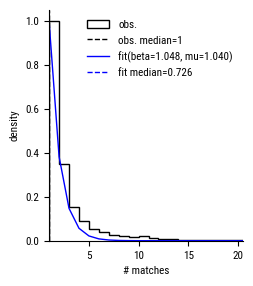

ppm=10.0 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
[1.00000000e+00 4.32474456e-01 2.31674811e-01 1.32385606e-01
 1.07063527e-01 7.08573967e-02 5.17547757e-02 3.95379831e-02
 3.19857841e-02 3.06530431e-02 2.17681031e-02 1.82141271e-02
 1.53265215e-02 1.39937805e-02 1.02176810e-02 9.10706353e-03
 5.99733452e-03 8.88494003e-03 7.33007552e-03 3.55397601e-03
 7.55219902e-03 5.10884052e-03 1.77698801e-03 4.66459351e-03
 3.33185251e-03 1.55486450e-03 1.77698801e-03 2.66548201e-03
 1.11061750e-03 1.11061750e-03 1.99911151e-03 1.77698801e-03
 8.88494003e-04 1.11061750e-03 2.22123501e-04 2.22123501e-04
 2.22123501e-04 2.22123501e-04 2.22123501e-04 2.22123501e-04
 0.00000000e+00 0.00000000e+00 4.44247001e-04 0.00000000e+00
 2.22123501e-04]


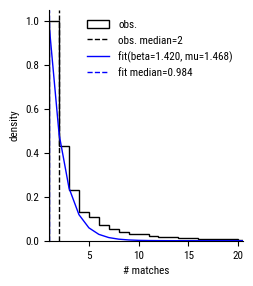

ppm=10.0 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74]
[1.00000000e+00 5.14277473e-01 3.13239112e-01 2.27862706e-01
 1.54600519e-01 1.11623882e-01 9.48947217e-02 6.74935102e-02
 5.22065186e-02 6.77819440e-02 5.07643496e-02 3.23045861e-02
 2.71127776e-02 2.56706086e-02 2.04788001e-02 2.33631382e-02
 1.44216902e-02 1.44216902e-02 1.32679550e-02 1.09604846e-02
 1.12489184e-02 1.64407269e-02 1.09604846e-02 5.48024228e-03
 1.00951832e-02 5.48024228e-03 3.17277185e-03 9.80674935e-03
 6.05710989e-03 6.63397750e-03 7.78771272e-03 3.74963946e-03
 2.30747044e-03 2.01903663e-03 8.65301413e-04 2.30747044e-03
 0.00000000e+00 5.76867609e-04 5.76867609e-04 1.44216902e-03
 2.30747044e-03 1.15373522e-03 2.88433804e-04 1.15373522e-03
 2.88433804e-04 1.15373522e-03 1.15373522e-03 2.01903663e-03
 2.59590424e-03 8.653014

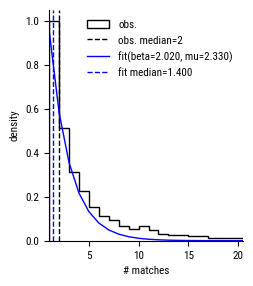

ppm=10.0 tol=1.6
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]
[1.00000000e+00 6.01138520e-01 4.15559772e-01 3.30929791e-01
 2.26565465e-01 1.66603416e-01 1.52182163e-01 1.19544592e-01
 8.46299810e-02 1.08159393e-01 8.12144213e-02 4.40227704e-02
 6.41366224e-02 6.03415560e-02 4.02277040e-02 4.17457306e-02
 3.79506641e-02 1.85958254e-02 1.63187856e-02 1.78368121e-02
 1.70777989e-02 2.58064516e-02 2.42884250e-02 2.16318786e-02
 1.02466793e-02 8.34914611e-03 9.86717268e-03 1.48007590e-02
 1.63187856e-02 7.21062619e-03 1.44212524e-02 6.83111954e-03
 1.13851992e-02 4.93358634e-03 8.34914611e-03 1.13851992e-03

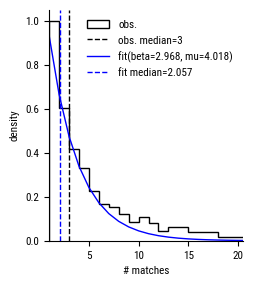

ppm=17.8 tol=0.1
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[1.         0.29572103 0.11238008 0.0525354  0.03334856 0.02040506
 0.01583676 0.01096391 0.0051774  0.01431399 0.00593878 0.00243642
 0.00182732 0.00182732 0.00213187 0.00137049 0.00137049 0.00228415
 0.00152277 0.00137049]


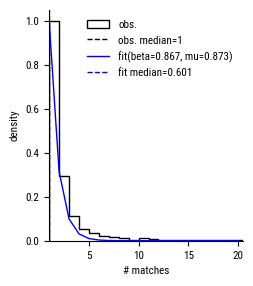

ppm=17.8 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
[1.00000000e+00 3.74013580e-01 1.74894476e-01 1.01486511e-01
 6.12956506e-02 4.29436594e-02 2.93631859e-02 2.47751881e-02
 1.59662323e-02 2.27564691e-02 1.65167921e-02 8.44191595e-03
 5.32207745e-03 4.40447789e-03 4.40447789e-03 2.20223894e-03
 3.30335841e-03 2.56927877e-03 3.30335841e-03 3.11983850e-03
 2.38575885e-03 2.01871903e-03 7.34079648e-04 9.17599560e-04
 1.83519912e-04 0.00000000e+00 0.00000000e+00 1.83519912e-04]


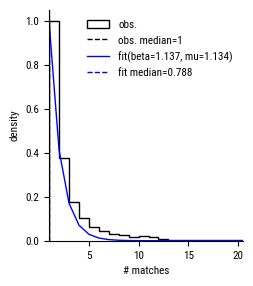

ppm=17.8 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48]
[1.00000000e+00 4.76538552e-01 2.57958029e-01 1.59396369e-01
 1.28507427e-01 7.42749352e-02 5.89483612e-02 4.71586890e-02
 3.63121905e-02 3.89059184e-02 2.24003773e-02 1.98066494e-02
 1.72129215e-02 1.72129215e-02 1.27328460e-02 9.90332469e-03
 1.13180854e-02 9.43173780e-03 7.78118368e-03 8.72435746e-03
 6.13062957e-03 3.30110823e-03 2.59372789e-03 4.71586890e-03
 2.82952134e-03 9.43173780e-04 1.17896722e-03 2.59372789e-03
 9.43173780e-04 4.71586890e-04 1.65055411e-03 2.35793445e-03
 1.65055411e-03 4.71586890e-04 4.71586890e-04 2.35793445e-04
 0.00000000e+00 4.71586890e-04 2.35793445e-04 4.71586890e-04
 2.35793445e-04 4.71586890e-04 7.07380335e-04 2.35793445e-04
 0.00000000e+00 7.07380335e-04 0.00000000e+00 2.35793445e-04]


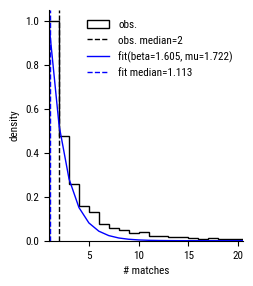

ppm=17.8 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86]
[1.00000000e+00 5.75441919e-01 3.74368687e-01 2.50000000e-01
 1.88762626e-01 1.37310606e-01 1.19002525e-01 7.44949495e-02
 7.03914141e-02 7.44949495e-02 6.21843434e-02 3.37752525e-02
 3.53535354e-02 2.99873737e-02 2.46212121e-02 2.14646465e-02
 1.35732323e-02 1.89393939e-02 1.73611111e-02 1.64141414e-02
 1.45202020e-02 1.57828283e-02 1.45202020e-02 1.10479798e-02
 8.52272727e-03 4.10353535e-03 5.36616162e-03 9.15404040e-03
 6.62878788e-03 5.36616162e-03 9.46969697e-03 5.68181818e-03
 3.78787879e-03 3.15656566e-03 9.46969697e-04 1.89393939e-03
 9.46969697e-04 6.31313131e-04 3.15656566e-04 2.20959596e-03
 1.89393939e-03 0.00000000e+00 3.15656566e-04 1.26262626e-03
 0.00000000e+00 1.57828283e-03 3.15656566e-04 3.1

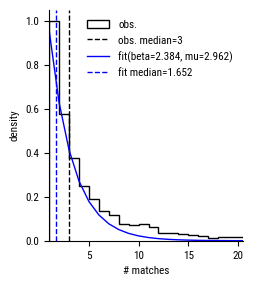

ppm=17.8 tol=1.6
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126]
[1.00000000e+00 7.17994628e-01 5.04028648e-01 3.96598030e-01
 2.98567592e-01 2.41271262e-01 1.92032229e-01 1.58012534e-01
 1.15040286e-01 1.32050134e-01 1.13697404e-01 7.02775291e-02
 7.56490600e-02 7.25156670e-02 5.28200537e-02 5.28200537e-02
 4.07341092e-02 3.13339302e-02 2.99910474e-02 3.58102059e-02
 2.01432408e-02 2.82005372e-02 2.64100269e-02 2.14861235e-02
 1.56669651e-02 1.11906893e-02 1.29811996e-02 1.61145927e-02
 2.14861235e-02 8.05729633e-03 1.38764548e-0

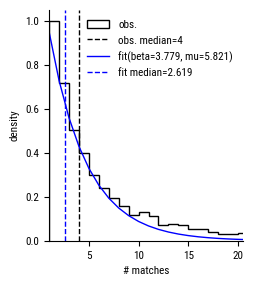

ppm=31.6 tol=0.1
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[1.00000000e+00 3.06258736e-01 1.25174717e-01 6.10343221e-02
 3.83599938e-02 2.31402392e-02 1.39773257e-02 1.11818605e-02
 5.59093027e-03 1.59962727e-02 6.52275198e-03 2.17425066e-03
 1.55303619e-03 2.48485790e-03 1.55303619e-03 1.70833980e-03
 1.24242895e-03 1.08712533e-03 9.31821711e-04 1.70833980e-03]


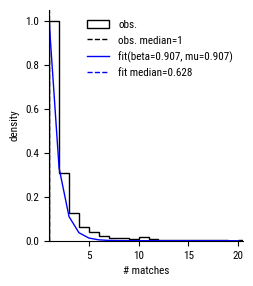

ppm=31.6 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
[1.00000000e+00 4.22144658e-01 1.95268567e-01 1.15377157e-01
 7.62070971e-02 4.94473531e-02 3.49040140e-02 2.69536552e-02
 1.57068063e-02 2.85049447e-02 1.60946287e-02 9.88947062e-03
 6.39906923e-03 3.87822377e-03 3.29649021e-03 1.93911189e-03
 3.29649021e-03 2.90866783e-03 1.93911189e-03 3.87822377e-03
 2.13302308e-03 1.93911189e-03 1.55128951e-03 1.93911189e-04
 1.93911189e-04 0.00000000e+00 5.81733566e-04 1.93911189e-04]


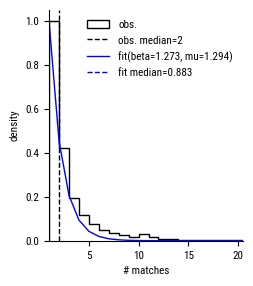

ppm=31.6 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
[1.00000000e+00 5.47318612e-01 3.26761304e-01 2.04258675e-01
 1.49053628e-01 1.03575184e-01 7.15036803e-02 5.94111462e-02
 4.25867508e-02 4.28496320e-02 2.73396425e-02 2.26077813e-02
 2.12933754e-02 2.05047319e-02 1.10410095e-02 1.02523659e-02
 1.44584648e-02 9.20084122e-03 8.14931651e-03 8.67507886e-03
 8.93796004e-03 6.83491062e-03 2.89169295e-03 3.41745531e-03
 3.15457413e-03 7.88643533e-04 1.84016824e-03 3.41745531e-03
 1.57728707e-03 2.62881178e-04 2.36593060e-03 1.57728707e-03
 1.31440589e-03 2.36593060e-03 0.00000000e+00 2.62881178e-04
 0.00000000e+00 1.05152471e-03 7.88643533e-04 0.00000000e+00
 2.62881178e-04 0.00000000e+00 5.25762355e-04 0.00000000e+00
 0.00000000e+00 5.25762355e-04]


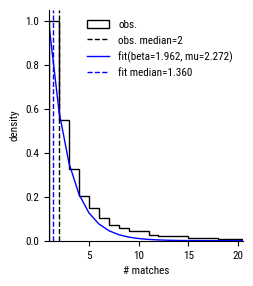

ppm=31.6 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
[1.00000000e+00 7.06269350e-01 4.91099071e-01 3.52554180e-01
 2.65092879e-01 2.07430341e-01 1.62925697e-01 1.14551084e-01
 1.03328173e-01 9.40402477e-02 7.46904025e-02 5.49535604e-02
 4.33436533e-02 4.02476780e-02 3.44427245e-02 2.82507740e-02
 3.17337461e-02 2.24458204e-02 2.08978328e-02 1.74148607e-02
 1.35448916e-02 1.93498452e-02 1.43188854e-02 1.12229102e-02
 1.23839009e-02 5.03095975e-03 5.03095975e-03 1.43188854e-02
 7.35294118e-03 5.03095975e-03 1.62538700e-02 4.64396285e-03
 6.57894737e-03 4.64396285e-03 2.32198142e-03 3.48297214e-03
 0.00000000e+00 1.93498452e-03 1.16099071e-03 1.54798762e-03
 5.03095975e-03 1.16099071e-03 1.93498452e-03 1.93498452e-03
 0.00000000e+00 3.86996904e-04 7.73993808e-04 3.86996904e-04
 3.09597523e-03 1.54798762e-03 1.16099071e-03 0.0000

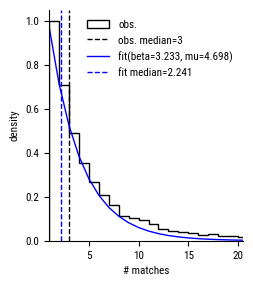

ppm=31.6 tol=1.6
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108]
[1.00000000e+00 7.71819738e-01 6.42897889e-01 5.28807758e-01
 4.38106104e-01 3.68511124e-01 2.92070736e-01 2.41300627e-01
 1.92812322e-01 2.08784940e-01 1.55733029e-01 1.07815174e-01
 1.23787792e-01 9.01312037e-02 7.58699373e-02 9.58357102e-02
 6.61722761e-02 4.27837992e-02 3.82201940e-02 4.16428979e-02
 2.22475756e-02 4.50656018e-02 3.59383913e-02 2.96634341e-02
 3.02338848e-02 1.02681118e-02 1.82544210e-02 1.59726184e-02
 1.42612664e-02 1.14090131e-02 3.13747861e-02 1.31203651e-02
 1.36908157e-02 9.12721050e-03 1.25499144e-02 7.41585853

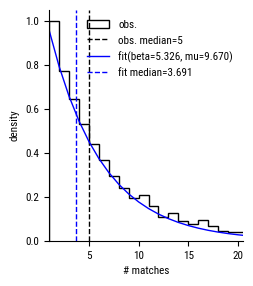

src_ids=(186,)
ppm=0.6 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 4.21424090e-01 2.03026976e-01 1.04218946e-01
 6.32057716e-02 3.53670013e-02 2.35257215e-02 1.19981179e-02
 9.09661230e-03 4.78356336e-03 3.29360100e-03 4.70514429e-04
 6.27352572e-04 1.56838143e-04 6.27352572e-04 1.56838143e-04
 7.84190715e-05]


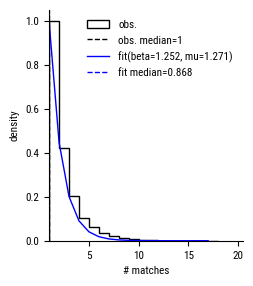

ppm=0.6 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[1.00000000e+00 5.37633285e-01 3.28245871e-01 1.94543174e-01
 1.24398913e-01 9.32469162e-02 6.73217646e-02 4.38009617e-02
 3.26155133e-02 2.48797826e-02 1.65168304e-02 1.26489651e-02
 7.10850930e-03 6.69036170e-03 6.06314029e-03 4.28601296e-03
 2.82249634e-03 1.56805352e-03 1.98620113e-03 6.27221409e-04
 1.25444282e-03 2.09073803e-04 1.04536902e-04 3.13610705e-04]


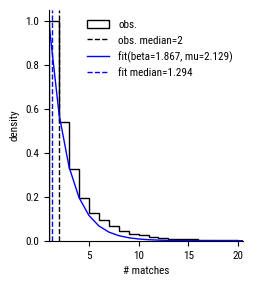

ppm=0.6 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
[1.00000000e+00 6.07831928e-01 4.19608404e-01 2.98842361e-01
 2.30384450e-01 1.69501215e-01 1.29912820e-01 1.20766043e-01
 8.84664856e-02 7.01729313e-02 5.47377447e-02 4.01600686e-02
 3.24424753e-02 3.43004145e-02 2.42961269e-02 2.14377590e-02
 1.15763899e-02 1.37201658e-02 1.21480635e-02 1.04330427e-02
 9.71845076e-03 4.28755181e-03 3.57295984e-03 4.85922538e-03
 3.28712305e-03 2.71544948e-03 2.57253108e-03 1.00042876e-03
 1.00042876e-03 1.14334715e-03 8.57510362e-04 1.14334715e-03
 1.00042876e-03 4.28755181e-04 4.28755181e-04 8.57510362e-04
 1.42918394e-04 2.85836787e-04]


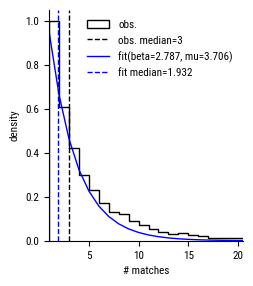

ppm=0.6 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55]
[1.00000000e+00 6.58408115e-01 5.04486929e-01 3.72610222e-01
 3.04330862e-01 2.57705813e-01 2.18298869e-01 1.80452595e-01
 1.52555599e-01 1.34412798e-01 1.09832228e-01 9.98829497e-02
 8.70074132e-02 7.02301990e-02 6.16465080e-02 4.97463909e-02
 4.76004682e-02 4.25282872e-02 3.53101834e-02 3.62856028e-02
 3.60905189e-02 2.78969957e-02 2.38002341e-02 1.77526336e-02
 2.26297308e-02 2.14592275e-02 1.75575497e-02 9.16894265e-03
 8.38860710e-03 8.58369099e-03 6.24268435e-03 6.43776824e-03
 7.41318767e-03 8.19352321e-03 3.90167772e-03 5.07218104e-03
 3.70659384e-03 1.95083886e-03 3.70659384e-03 2.34100663e-03
 2.34100663e-03 2.53609052e-03 2.53609052e-03 9.75419430e-04
 1.56067109e-03 1.95083886e-04 7.80335544e-04 1.95083886e-04
 2.14592275e-03 5.85251658e-04 9.75419430e-04 3.90167772e-04
 0.00000000e+00 5.8525

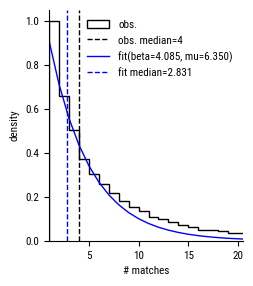

ppm=1.0 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 4.26928228e-01 2.07122036e-01 1.06594186e-01
 6.33419995e-02 3.56101788e-02 2.35562909e-02 1.22114551e-02
 8.19349248e-03 5.43606712e-03 3.07255968e-03 1.02418656e-03
 3.15134326e-04 3.15134326e-04 5.51485071e-04 1.57567163e-04
 7.87835815e-05]


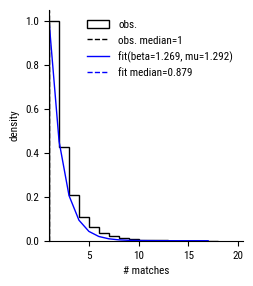

ppm=1.0 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[1.00000000e+00 5.30445700e-01 3.33751831e-01 1.98472484e-01
 1.31931366e-01 9.34295878e-02 6.41347562e-02 4.50931157e-02
 3.47353003e-02 2.21803725e-02 1.76815233e-02 1.32872986e-02
 6.90521030e-03 5.96359071e-03 5.44046872e-03 3.66185394e-03
 3.13873195e-03 1.04624398e-03 2.09248797e-03 1.56936598e-03
 4.18497594e-04 1.04624398e-04 3.13873195e-04 0.00000000e+00
 1.04624398e-04]


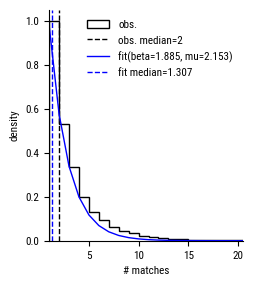

ppm=1.0 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[1.00000000e+00 6.08045977e-01 4.20833333e-01 3.12068966e-01
 2.43534483e-01 1.70689655e-01 1.37643678e-01 1.15660920e-01
 8.69252874e-02 6.53735632e-02 5.18678161e-02 4.06609195e-02
 3.36206897e-02 3.64942529e-02 2.50000000e-02 1.86781609e-02
 1.32183908e-02 1.26436782e-02 1.27873563e-02 8.04597701e-03
 1.06321839e-02 6.32183908e-03 4.02298851e-03 4.88505747e-03
 3.44827586e-03 1.86781609e-03 2.15517241e-03 8.62068966e-04
 1.14942529e-03 1.58045977e-03 7.18390805e-04 1.14942529e-03
 0.00000000e+00 7.18390805e-04 5.74712644e-04 4.31034483e-04
 1.43678161e-04 4.31034483e-04 1.43678161e-04]


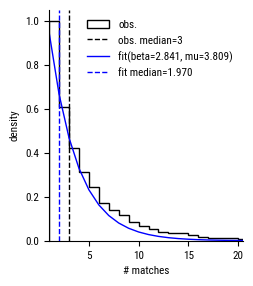

ppm=1.0 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55]
[1.00000000e+00 6.78142514e-01 5.15212170e-01 3.87910328e-01
 3.44275420e-01 2.68414732e-01 2.24779824e-01 1.94355484e-01
 1.60328263e-01 1.34507606e-01 1.12489992e-01 9.64771817e-02
 8.20656525e-02 6.90552442e-02 7.22578062e-02 4.90392314e-02
 4.98398719e-02 4.32345877e-02 3.36269015e-02 3.26261009e-02
 3.64291433e-02 3.44275420e-02 2.60208167e-02 1.84147318e-02
 2.20176141e-02 1.94155324e-02 1.90152122e-02 8.60688551e-03
 1.00080064e-02 8.20656525e-03 6.00480384e-03 4.60368295e-03
 8.80704564e-03 7.80624500e-03 4.80384307e-03 4.60368295e-03
 3.00240192e-03 2.40192154e-03 2.40192154e-03 2.40192154e-03
 1.40112090e-03 2.40192154e-03 3.00240192e-03 4.00320256e-04
 1.40112090e-03 8.00640512e-04 6.00480384e-04 0.00000000e+00
 1.80144115e-03 1.20096077e-03 8.00640512e-04 2.00160128e-04
 4.00320256e-04 2.0016

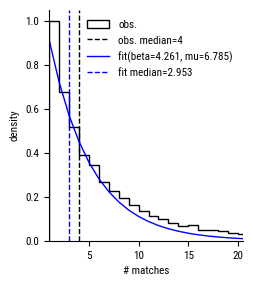

ppm=1.8 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 4.20726869e-01 2.14807173e-01 1.08712903e-01
 6.23710522e-02 3.49944453e-02 2.42818600e-02 1.40453896e-02
 9.68100302e-03 3.88827170e-03 2.85668941e-03 7.93524837e-04
 5.55467386e-04 2.38057451e-04 4.76114902e-04 2.38057451e-04
 3.17409935e-04]


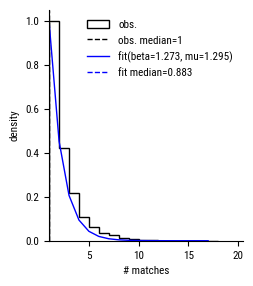

ppm=1.8 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[1.00000000e+00 5.49082716e-01 3.45027358e-01 2.00944105e-01
 1.35929621e-01 1.03422380e-01 6.60873297e-02 4.44158352e-02
 3.35800880e-02 2.48900333e-02 2.00622251e-02 1.18013089e-02
 8.69005472e-03 4.72052355e-03 5.14966205e-03 4.61323892e-03
 3.54039266e-03 9.65561635e-04 2.03840790e-03 1.18013089e-03
 5.36423131e-04 2.14569252e-04 1.07284626e-04 2.14569252e-04
 2.14569252e-04]


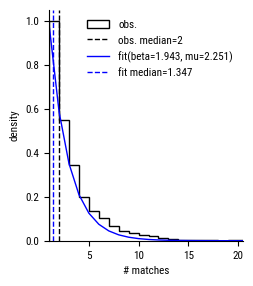

ppm=1.8 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
[1.00000000e+00 6.09229404e-01 4.56737169e-01 3.24951930e-01
 2.40792782e-01 1.82369472e-01 1.40068037e-01 1.24981512e-01
 8.87442686e-02 6.89247153e-02 5.30986540e-02 4.45200414e-02
 3.25395652e-02 3.19479367e-02 2.91377015e-02 2.08549031e-02
 1.25721047e-02 1.50865257e-02 1.18325691e-02 9.61396243e-03
 1.10930336e-02 4.88093477e-03 5.02884189e-03 3.69767786e-03
 4.43721343e-03 2.07069960e-03 2.95814229e-03 1.33116403e-03
 5.91628457e-04 1.62697826e-03 5.91628457e-04 8.87442686e-04
 4.43721343e-04 2.95814229e-04 1.47907114e-04 7.39535572e-04
 4.43721343e-04 2.95814229e-04]


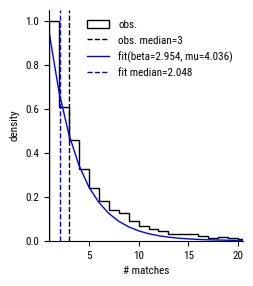

ppm=1.8 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55]
[1.00000000e+00 6.78549093e-01 5.36793829e-01 4.21096519e-01
 3.52511987e-01 2.84344382e-01 2.39733167e-01 1.98874296e-01
 1.70731707e-01 1.49676881e-01 1.07775693e-01 1.04857202e-01
 9.86032937e-02 8.08838858e-02 6.92099229e-02 4.75297061e-02
 5.31582239e-02 4.66958516e-02 3.71065249e-02 3.48134251e-02
 4.02334793e-02 2.75171982e-02 2.60579529e-02 1.87617261e-02
 1.95955806e-02 2.18886804e-02 1.66770898e-02 1.29247446e-02
 1.16739629e-02 1.08401084e-02 8.96393579e-03 6.87929956e-03
 9.17239942e-03 5.83698145e-03 4.37773609e-03 5.21159058e-03
 5.00312695e-03 2.29309985e-03 2.71002710e-03 1.87617261e-03
 1.66770898e-03 3.75234522e-03 2.29309985e-03 6.25390869e-04
 3.12695435e-03 0.00000000e+00 4.16927246e-04 8.33854492e-04
 1.87617261e-03 8.33854492e-04 6.25390869e-04 0.00000000e+00
 2.08463623e-04 4.1692

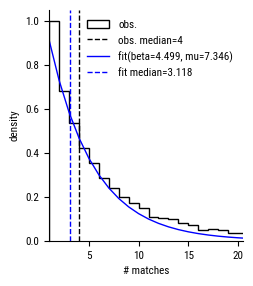

ppm=3.2 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 4.65034103e-01 2.33790780e-01 1.21784863e-01
 6.62338730e-02 3.91979620e-02 2.48171584e-02 1.41342756e-02
 1.03541787e-02 3.61574493e-03 2.95833676e-03 1.39699236e-03
 7.39584189e-04 2.46528063e-04 3.28704084e-04 1.64352042e-04
 2.46528063e-04]


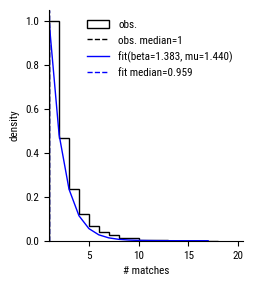

ppm=3.2 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
[1.00000000e+00 6.03048226e-01 3.77047316e-01 2.41810737e-01
 1.54572338e-01 1.10668790e-01 7.49545041e-02 5.31164695e-02
 3.43494086e-02 2.75250227e-02 1.96769791e-02 1.35350318e-02
 9.21292084e-03 6.93812557e-03 5.34576888e-03 5.23202912e-03
 4.43585077e-03 1.25113740e-03 1.93357598e-03 1.47861692e-03
 7.96178344e-04 1.13739763e-04 3.41219290e-04 1.13739763e-04]


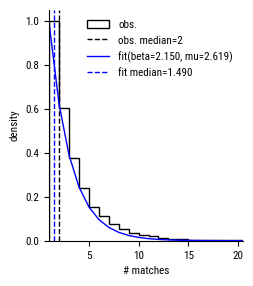

ppm=3.2 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
[1.00000000e+00 6.91688568e-01 5.02956636e-01 3.99145861e-01
 3.00591327e-01 2.13042050e-01 1.77398160e-01 1.36333771e-01
 1.08574244e-01 8.75492773e-02 6.68528252e-02 4.79632063e-02
 4.02431012e-02 3.38370565e-02 3.26872536e-02 2.48028909e-02
 1.62614980e-02 1.49474376e-02 1.36333771e-02 1.24835742e-02
 1.13337714e-02 5.74901445e-03 4.92772668e-03 5.58475690e-03
 5.42049934e-03 2.46386334e-03 2.62812089e-03 1.80683311e-03
 8.21287779e-04 1.31406045e-03 4.92772668e-04 9.85545335e-04
 3.28515112e-04 1.14980289e-03 8.21287779e-04 6.57030223e-04
 1.64257556e-04 1.64257556e-04]


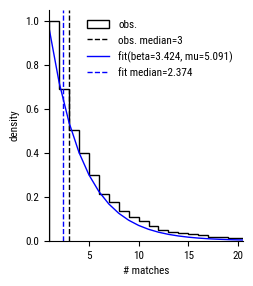

ppm=3.2 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55]
[1.00000000e+00 7.76611328e-01 6.07177734e-01 5.22216797e-01
 4.24560547e-01 3.66699219e-01 3.10058594e-01 2.52929688e-01
 2.18505859e-01 1.99462891e-01 1.70166016e-01 1.32080078e-01
 1.24511719e-01 9.66796875e-02 9.22851562e-02 6.05468750e-02
 5.68847656e-02 5.56640625e-02 4.90722656e-02 4.88281250e-02
 5.20019531e-02 3.44238281e-02 2.70996094e-02 2.85644531e-02
 2.56347656e-02 2.49023438e-02 2.27050781e-02 1.44042969e-02
 1.24511719e-02 1.19628906e-02 9.76562500e-03 6.59179688e-03
 8.05664062e-03 7.81250000e-03 4.88281250e-03 5.37109375e-03
 6.83593750e-03 2.92968750e-03 3.41796875e-03 2.92968750e-03
 1.70898438e-03 4.15039062e-03 3.66210938e-03 7.32421875e-04
 2.44140625e-03 4.88281250e-04 7.32421875e-04 7.32421875e-04
 2.19726562e-03 7.32421875e-04 1.22070312e-03 4.88281250e-04
 0.00000000e+00 0.0000

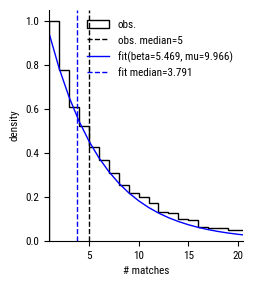

ppm=5.6 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 5.23713421e-01 2.83735437e-01 1.52279607e-01
 8.84322539e-02 5.07292909e-02 3.25658196e-02 1.79800018e-02
 1.16503073e-02 6.69663334e-03 4.03632694e-03 2.20163288e-03
 6.42142923e-04 2.75204110e-04 8.25612329e-04 9.17347032e-05
 3.66938813e-04]


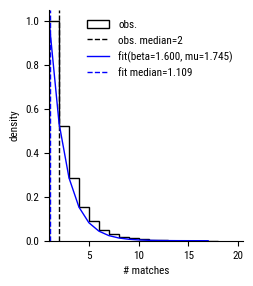

ppm=5.6 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[1.00000000e+00 6.96003230e-01 4.65482438e-01 3.15300767e-01
 2.02126228e-01 1.48297672e-01 1.04427399e-01 7.49562643e-02
 5.30211277e-02 3.75454178e-02 2.36845647e-02 1.88399946e-02
 1.50719957e-02 9.15085453e-03 9.55456870e-03 5.24828421e-03
 5.24828421e-03 2.28771363e-03 2.69142780e-03 1.21114251e-03
 1.21114251e-03 2.69142780e-04 5.38285560e-04 0.00000000e+00
 2.69142780e-04]


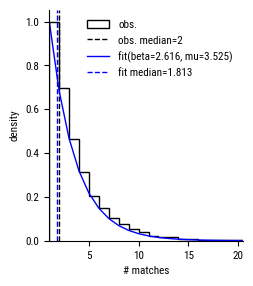

ppm=5.6 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
[1.00000000e+00 7.83127572e-01 6.34156379e-01 4.94444444e-01
 3.92386831e-01 3.04938272e-01 2.43621399e-01 2.09876543e-01
 1.58641975e-01 1.16872428e-01 1.01851852e-01 8.49794239e-02
 5.82304527e-02 6.37860082e-02 4.30041152e-02 3.39506173e-02
 2.51028807e-02 2.42798354e-02 2.11934156e-02 1.41975309e-02
 1.81069959e-02 1.09053498e-02 7.61316872e-03 7.40740741e-03
 7.20164609e-03 5.76131687e-03 3.90946502e-03 1.44032922e-03
 2.26337449e-03 1.64609053e-03 1.44032922e-03 1.23456790e-03
 8.23045267e-04 1.23456790e-03 1.02880658e-03 4.11522634e-04
 0.00000000e+00 2.05761317e-04]


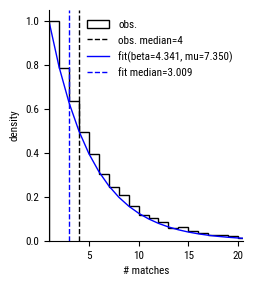

ppm=5.6 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56]
[1.00000000e+00 8.78510777e-01 7.33180927e-01 6.42390594e-01
 5.60744611e-01 4.91508818e-01 4.43500980e-01 4.00718485e-01
 3.14500327e-01 2.97517962e-01 2.44611365e-01 2.17831483e-01
 1.92031352e-01 1.57740039e-01 1.38145003e-01 1.15284128e-01
 1.07772698e-01 9.86283475e-02 8.16459830e-02 7.54408883e-02
 7.08687133e-02 7.11952972e-02 5.42129327e-02 4.11495754e-02
 4.44154148e-02 4.44154148e-02 3.42913129e-02 3.29849771e-02
 1.66557805e-02 2.12279556e-02 1.37165251e-02 1.53494448e-02
 1.69823645e-02 1.01241019e-02 9.79751796e-03 5.87851078e-03
 7.51143044e-03 4.89875898e-03 3.59242325e-03 5.22534291e-03
 5.87851078e-03 4.24559112e-03 5.22534291e-03 2.61267146e-03
 3.59242325e-03 6.53167864e-04 1.63291966e-03 1.30633573e-03
 6.53167864e-04 6.53167864e-04 1.63291966e-03 6.53167864e-04
 3.26583932e-04 6.5

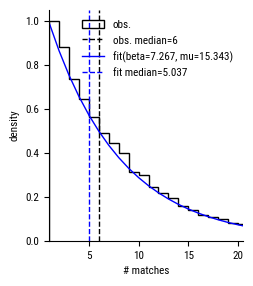

ppm=10.0 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[1.00000000e+00 6.16719577e-01 3.84761905e-01 2.00105820e-01
 1.33756614e-01 7.90476190e-02 4.95238095e-02 2.92063492e-02
 2.00000000e-02 1.22751323e-02 7.19576720e-03 3.80952381e-03
 1.26984127e-03 2.11640212e-04 1.16402116e-03 4.23280423e-04
 3.17460317e-04]


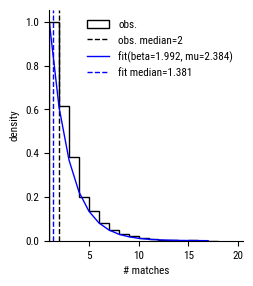

ppm=10.0 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
[1.00000000e+00 7.73662551e-01 5.88971193e-01 4.31934156e-01
 2.91193416e-01 2.18930041e-01 1.75802469e-01 1.30370370e-01
 8.95473251e-02 6.93004115e-02 4.85596708e-02 3.78600823e-02
 2.35390947e-02 2.02469136e-02 1.56378601e-02 8.88888889e-03
 6.91358025e-03 4.11522634e-03 5.92592593e-03 3.29218107e-03
 3.62139918e-03 8.23045267e-04 9.87654321e-04 3.29218107e-04
 1.64609053e-04 1.64609053e-04]


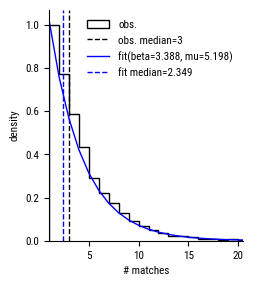

ppm=10.0 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
[1.00000000e+00 8.68922912e-01 7.18506581e-01 6.31748590e-01
 5.59495031e-01 4.53666398e-01 3.45151759e-01 3.09159280e-01
 2.56513564e-01 2.26161698e-01 1.90706420e-01 1.60354553e-01
 1.28928284e-01 1.09857642e-01 9.50846092e-02 6.60757454e-02
 5.53317217e-02 4.61993016e-02 4.48562987e-02 2.41740532e-02
 2.60542573e-02 2.09508461e-02 2.20252485e-02 1.58474349e-02
 1.74590384e-02 1.02068225e-02 9.66962127e-03 7.52081655e-03
 5.10341123e-03 2.95460650e-03 5.37201182e-03 3.22320709e-03
 1.07440236e-03 2.95460650e-03 2.68600591e-03 1.34300295e-03
 5.37201182e-04 5.37201182e-04 0.00000000e+00 2.68600591e-04]


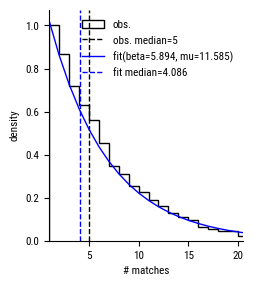

ppm=10.0 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56]
[1.00000000e+00 8.85701677e-01 8.32744925e-01 7.06972639e-01
 6.68137688e-01 6.10767873e-01 6.20917917e-01 5.55604590e-01
 4.77493380e-01 4.33804060e-01 3.80406002e-01 3.40247132e-01
 3.18623124e-01 2.89055605e-01 2.66107679e-01 2.38305384e-01
 2.27272727e-01 1.82259488e-01 1.68578994e-01 1.62400706e-01
 1.47837599e-01 1.35922330e-01 1.11209179e-01 8.03177405e-02
 7.89938217e-02 8.69373345e-02 8.07590468e-02 6.26654898e-02
 4.85436893e-02 4.72197705e-02 4.36893204e-02 2.55957635e-02
 2.91262136e-02 3.35392763e-02 2.20653133e-02 1.85348632e-02
 2.33892321e-02 1.72109444e-02 1.41218005e-02 1.10326567e-02
 1.63283319e-02 1.67696381e-02 1.76522507e-02 9.70873786e-03
 6.61959400e-03 3.53045013e-03 6.17828773e-03 6.61959400e-03
 6.61959400e-03 5.29567520e-03 4.41306267e-03 1.32391880e-03
 3.53045013e-03 1.

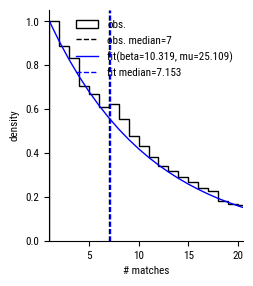

ppm=17.8 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[1.00000000e+00 7.10793773e-01 4.91959346e-01 3.24070500e-01
 2.03910974e-01 1.35983533e-01 8.61958060e-02 4.91444745e-02
 3.07474592e-02 1.89116171e-02 1.29936961e-02 7.07577512e-03
 4.50276598e-03 1.15785411e-03 7.71902740e-04 6.43252284e-04
 5.14601827e-04 1.28650457e-04]


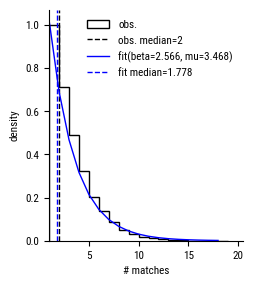

ppm=17.8 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
[1.00000000e+00 8.58494624e-01 7.29677419e-01 5.83655914e-01
 4.56344086e-01 3.68172043e-01 2.84516129e-01 2.28387097e-01
 1.67956989e-01 1.25161290e-01 9.20430108e-02 7.11827957e-02
 4.25806452e-02 4.06451613e-02 2.88172043e-02 2.06451613e-02
 1.52688172e-02 7.95698925e-03 1.03225806e-02 5.80645161e-03
 4.73118280e-03 1.72043011e-03 8.60215054e-04 1.07526882e-03
 1.29032258e-03 4.30107527e-04]


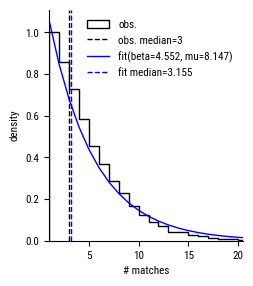

ppm=17.8 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
[1.00000000e+00 9.23189466e-01 8.07607901e-01 7.23116313e-01
 6.79956108e-01 6.14484272e-01 5.64008778e-01 4.97805413e-01
 4.32333577e-01 3.84052670e-01 3.31748354e-01 2.86393563e-01
 2.43964887e-01 2.14703731e-01 1.80687637e-01 1.47403072e-01
 1.32772495e-01 9.94879298e-02 9.47329920e-02 6.43745428e-02
 5.99853694e-02 4.64520849e-02 4.71836138e-02 2.88953914e-02
 3.54791514e-02 2.88953914e-02 1.79224579e-02 2.08485735e-02
 1.28017557e-02 3.65764448e-03 4.75493782e-03 6.94952451e-03
 2.92611558e-03 5.12070227e-03 4.38917337e-03 2.19458669e-03
 3.65764448e-04 1.46305779e-03 1.46305779e-03 7.31528895e-04]


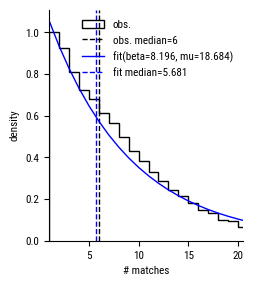

ppm=17.8 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70]
[1.00000000e+00 9.36061381e-01 8.93861893e-01 8.07544757e-01
 8.03708440e-01 7.53196931e-01 7.30818414e-01 7.25703325e-01
 6.47058824e-01 6.49616368e-01 5.95907928e-01 5.42199488e-01
 5.42838875e-01 5.14705882e-01 4.66112532e-01 3.94501279e-01
 4.05370844e-01 3.71483376e-01 3.23529412e-01 2.94757033e-01
 3.10102302e-01 2.99232737e-01 2.18670077e-01 2.05882353e-01
 1.64322251e-01 1.77749361e-01 1.86700767e-01 1.63043478e-01
 1.53452685e-01 1.15089514e-01 1.32352941e-01 1.02301790e-01
 8.05626598e-02 8.31202046e-02 6.39386189e-02 5.30690537e-02
 4.92327366e-02 4.73145780e-02 2.74936061e-02 4.09207161e-02
 3.38874680e-02 2.10997442e-02 3.06905371e-02 2.68542199e-02
 1.91815857e-02 1.34271100e-02 7.67263427e-03 1.53452685e-02
 1.27877238e-02 1.72634271e-02 8.3120

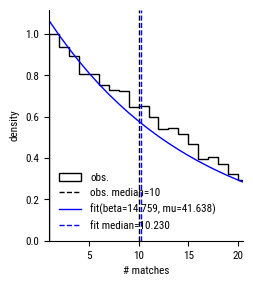

ppm=31.6 tol=0.2
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1.00000000e+00 8.22171341e-01 6.49494371e-01 5.46842206e-01
 4.26063728e-01 3.25510399e-01 2.44037397e-01 1.58557527e-01
 1.21160084e-01 8.43350506e-02 5.57145583e-02 3.89238695e-02
 2.90020988e-02 1.52642625e-02 1.10665903e-02 6.48731158e-03
 4.38847548e-03 1.90803282e-03 1.71722954e-03 1.90803282e-04
 0.00000000e+00 0.00000000e+00 5.72409845e-04]


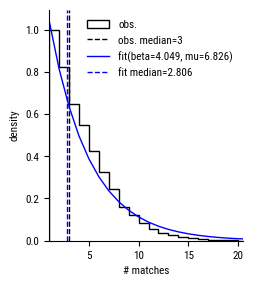

ppm=31.6 tol=0.4
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
[1.00000000e+00 8.85846255e-01 8.19201584e-01 7.31771693e-01
 6.12339162e-01 5.59881227e-01 5.09732761e-01 4.67502474e-01
 3.96568789e-01 3.48069944e-01 2.78126031e-01 2.23028703e-01
 1.88056747e-01 1.67271528e-01 1.38568129e-01 1.20422303e-01
 8.90795117e-02 6.99439129e-02 6.43352029e-02 4.38799076e-02
 3.36522600e-02 3.10128670e-02 2.21049159e-02 1.51765094e-02
 9.89772352e-03 9.56779941e-03 7.58825470e-03 6.59848235e-03
 1.31969647e-03 1.31969647e-03 9.89772352e-04 0.00000000e+00
 0.00000000e+00 1.31969647e-03 3.29924117e-04 1.31969647e-03
 3.29924117e-04]


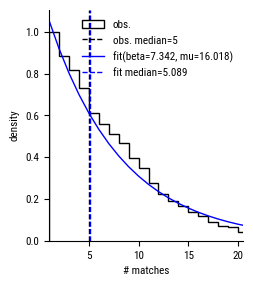

ppm=31.6 tol=0.8
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
[1.00000000e+00 9.44084756e-01 8.72277810e-01 8.08122425e-01
 7.64567393e-01 7.53384344e-01 6.99823426e-01 6.79811654e-01
 6.22719247e-01 5.26191878e-01 5.23837552e-01 5.13831666e-01
 5.16185992e-01 4.33784579e-01 3.91406710e-01 3.82577987e-01
 3.43143025e-01 3.80223661e-01 3.04296645e-01 2.78987640e-01
 2.38964097e-01 2.23072396e-01 2.28369629e-01 1.92466157e-01
 1.73042966e-01 1.56562684e-01 1.40670983e-01 1.14184815e-01
 1.16539141e-01 8.53443202e-02 8.47557387e-02 8.06356680e-02
 8.12242496e-02 6.53325486e-02 5.47380812e-02 4.47321954e-02
 3.47263096e-02 3.06062390e-02 2.58975868e-02 2.00117716e-02
 2.29546792e-02 1.64802825e-02 6.47439670e-03 7.06297822e-03
 3.53148911e-03 4.70865215e-03 4.12007063e-03 1.76574456e-03
 4.12007063e-03 3.53148911e-03 1.76574456e-03 1.76574456e-

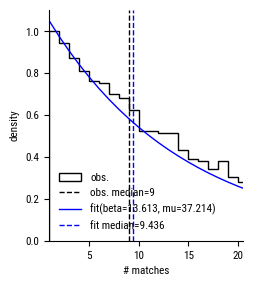

ppm=31.6 tol=1.6
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110]
[1.00000000e+00 9.04808636e-01 8.77330716e-01 7.41903827e-01
 8.01766438e-01 7.27183513e-01 7.35034347e-01 7.26202159e-01
 6.56526006e-01 7.27183513e-01 6.63395486e-01 6.00588813e-01
 6.31010795e-01 6.50637880e-01 6.57507360e-01 5.76054956e-01
 5.40726202e-01 5.26005888e-01 5.29931305e-01 4.57311089e-01
 4.62217861e-01 3.99411187e-01 4.87733072e-01 3.66045142e-01
 4.05299313e-01 3.86653582e-01 3.80765456e-01 3.97448479e-01
 3.61138371e-01 3.55250245e-01 3.42492640e-01 2.96368989e-01
 3.12070658e-01 3.09126595e-01 2.62021590e-01 2

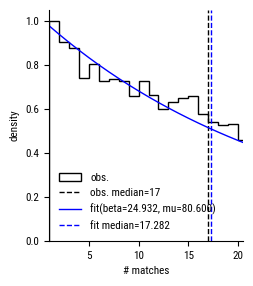

src_ids=(374, 375)
ppm=0.6 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[1.00000000e+00 1.21204989e-01 3.64791716e-02 1.36502707e-02
 6.35443634e-03 1.41209696e-03 7.06048482e-04 1.41209696e-03
 2.35349494e-04 4.70698988e-04 2.35349494e-04 4.70698988e-04]


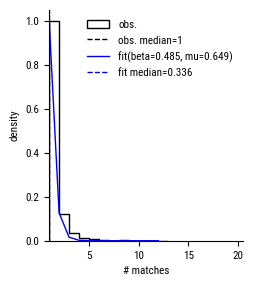

ppm=0.6 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[1.00000000e+00 1.57921292e-01 5.87790111e-02 2.37134208e-02
 1.21089808e-02 7.56811302e-03 2.01816347e-03 1.76589304e-03
 1.51362260e-03 7.56811302e-04 5.04540868e-04 1.00908174e-03]


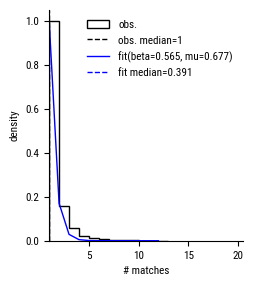

ppm=0.6 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[1.00000000e+00 2.04401651e-01 8.17056396e-02 3.60385144e-02
 2.28335626e-02 1.21045392e-02 9.07840440e-03 5.50206327e-03
 3.57634113e-03 1.92572215e-03 1.92572215e-03 8.25309491e-04
 8.25309491e-04 1.65061898e-03]


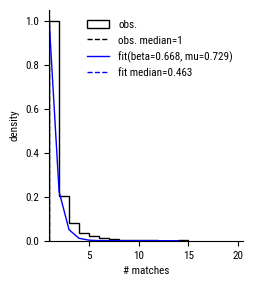

ppm=0.6 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[1.00000000e+00 2.28202044e-01 1.20565244e-01 5.08117859e-02
 3.51773903e-02 2.04449790e-02 1.47324113e-02 1.44317498e-02
 8.11785929e-03 3.00661455e-03 4.81058328e-03 9.01984366e-04
 1.50330728e-03 1.20264582e-03 4.20926037e-03 3.00661455e-04
 3.00661455e-04 9.01984366e-04 9.01984366e-04 3.00661455e-04]


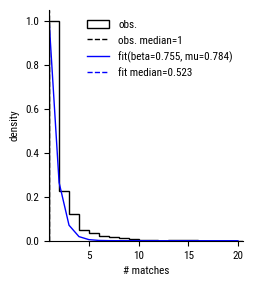

ppm=1.0 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[1.00000000e+00 1.62315271e-01 5.27093596e-02 2.21674877e-02
 7.14285714e-03 5.17241379e-03 1.23152709e-03 1.47783251e-03
 1.23152709e-03 2.46305419e-04 4.92610837e-04 2.46305419e-04]


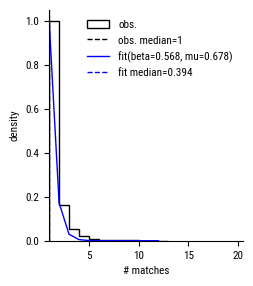

ppm=1.0 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[1.00000000e+00 2.03258547e-01 8.19978632e-02 3.63247863e-02
 1.52243590e-02 8.81410256e-03 4.27350427e-03 3.47222222e-03
 1.86965812e-03 2.40384615e-03 8.01282051e-04 1.60256410e-03
 2.67094017e-04]


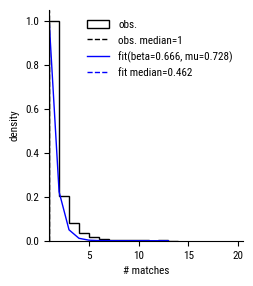

ppm=1.0 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[1.00000000e+00 2.61721068e-01 1.00593472e-01 4.92581602e-02
 3.85756677e-02 2.25519288e-02 1.39465875e-02 7.12166172e-03
 6.23145401e-03 1.18694362e-03 2.07715134e-03 2.07715134e-03
 2.96735905e-03 2.07715134e-03 5.93471810e-04 2.96735905e-04]


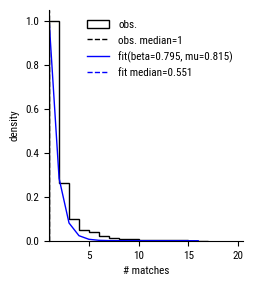

ppm=1.0 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
[1.00000000e+00 2.77502478e-01 1.50313842e-01 7.00363396e-02
 4.92236538e-02 4.32771721e-02 2.74198877e-02 1.81698051e-02
 1.15626032e-02 8.58936241e-03 9.58044268e-03 2.31252065e-03
 1.98216056e-03 3.63396102e-03 4.29468120e-03 6.60720185e-04
 0.00000000e+00 6.60720185e-04 3.30360093e-04 9.91080278e-04
 9.91080278e-04 6.60720185e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.30360093e-04]


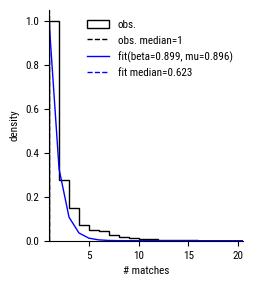

ppm=1.8 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[1.00000000e+00 1.72005044e-01 6.25472888e-02 3.20302648e-02
 1.96721311e-02 6.55737705e-03 3.02648172e-03 1.76544767e-03
 2.52206810e-04 0.00000000e+00 5.04413619e-04 2.52206810e-04]


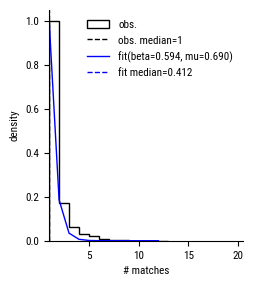

ppm=1.8 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[1.00000000e+00 1.93792173e-01 8.25910931e-02 4.53441296e-02
 2.67206478e-02 1.67341430e-02 8.36707152e-03 6.47773279e-03
 5.39811066e-03 1.61943320e-03 1.61943320e-03 8.09716599e-04
 2.69905533e-04]


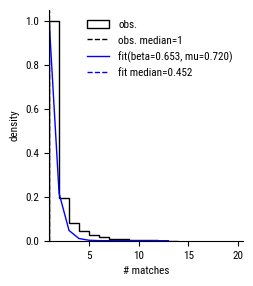

ppm=1.8 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[1.00000000e+00 2.42487355e-01 8.65813746e-02 7.11097888e-02
 3.92740256e-02 2.79678667e-02 1.66617078e-02 1.39839334e-02
 1.24962809e-02 7.43826242e-03 1.78518298e-03 6.24814043e-03
 2.08271348e-03 1.78518298e-03 0.00000000e+00 5.95060994e-04
 1.19012199e-03 2.97530497e-04]


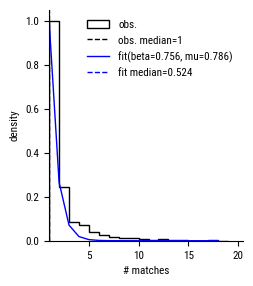

ppm=1.8 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
[1.00000000e+00 2.78666667e-01 1.21333333e-01 7.33333333e-02
 5.63333333e-02 4.53333333e-02 3.20000000e-02 1.56666667e-02
 2.80000000e-02 1.90000000e-02 1.10000000e-02 8.33333333e-03
 7.33333333e-03 4.00000000e-03 3.00000000e-03 3.00000000e-03
 3.33333333e-04 3.00000000e-03 2.00000000e-03 1.33333333e-03
 0.00000000e+00 1.33333333e-03 6.66666667e-04 6.66666667e-04
 0.00000000e+00 0.00000000e+00 6.66666667e-04]


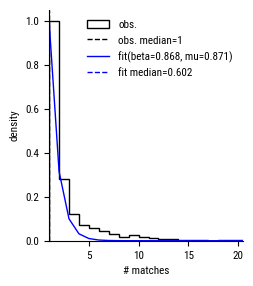

ppm=3.2 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11]
[1.00000000e+00 1.60937102e-01 7.41023682e-02 3.59052712e-02
 1.60427807e-02 8.91265597e-03 3.05576776e-03 1.52788388e-03
 7.63941940e-04 1.01858925e-03 7.63941940e-04]


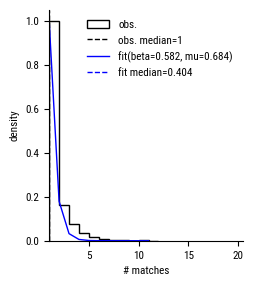

ppm=3.2 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13]
[1.         0.18441841 0.08989376 0.04630891 0.02778534 0.01770635
 0.01062381 0.00544811 0.00381367 0.00326886 0.00136203 0.00163443
 0.00163443]


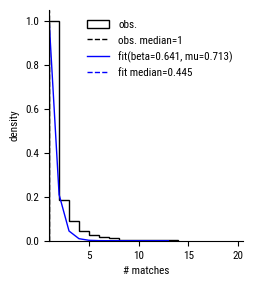

ppm=3.2 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[1.00000000e+00 2.53919459e-01 1.09130034e-01 6.11743006e-02
 4.82631417e-02 2.82815862e-02 2.52075008e-02 1.13741162e-02
 7.68521365e-03 5.84076237e-03 4.61112819e-03 3.38149401e-03
 3.07408546e-03 4.61112819e-03 1.84445128e-03 1.22963418e-03
 3.07408546e-04 9.22225638e-04 6.14817092e-04 6.14817092e-04
 0.00000000e+00 0.00000000e+00 9.22225638e-04]


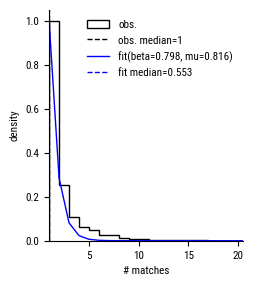

ppm=3.2 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
[1.00000000e+00 3.01893408e-01 1.46213184e-01 8.45021038e-02
 7.29312763e-02 4.24263675e-02 3.71669004e-02 2.62973352e-02
 1.99859748e-02 1.12201964e-02 8.06451613e-03 1.12201964e-02
 5.61009818e-03 2.80504909e-03 3.85694250e-03 2.45441795e-03
 1.75315568e-03 3.15568022e-03 1.05189341e-03 2.45441795e-03
 2.80504909e-03 1.75315568e-03 3.50631136e-04 3.50631136e-04
 7.01262272e-04 0.00000000e+00 3.50631136e-04 0.00000000e+00
 1.05189341e-03 0.00000000e+00 7.01262272e-04 0.00000000e+00
 7.01262272e-04 3.50631136e-04]


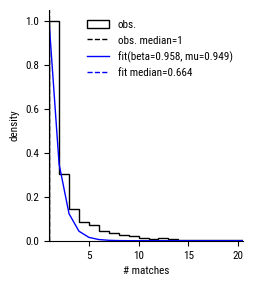

ppm=5.6 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[1.00000000e+00 2.11496746e-01 6.94143167e-02 3.47071584e-02
 1.95227766e-02 1.19305857e-02 3.25379610e-03 2.44034707e-03
 1.35574837e-03 2.71149675e-04 1.08459870e-03 0.00000000e+00
 5.42299349e-04 1.08459870e-03 2.71149675e-04]


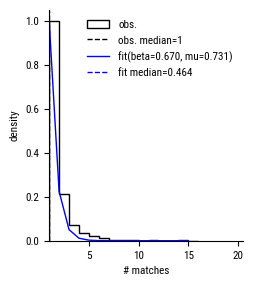

ppm=5.6 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[1.00000000e+00 2.57784431e-01 1.00598802e-01 5.02994012e-02
 2.84431138e-02 2.24550898e-02 1.58682635e-02 6.88622754e-03
 3.59281437e-03 2.09580838e-03 2.99401198e-03 3.59281437e-03
 2.39520958e-03 1.19760479e-03 2.99401198e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.99401198e-04]


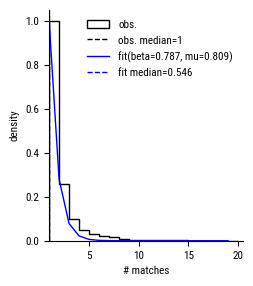

ppm=5.6 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
[1.00000000e+00 3.21038251e-01 1.31489071e-01 7.24043716e-02
 6.31830601e-02 2.97131148e-02 2.59562842e-02 1.19535519e-02
 1.22950820e-02 1.02459016e-02 3.75683060e-03 7.51366120e-03
 4.78142077e-03 5.80601093e-03 1.70765027e-03 3.07377049e-03
 2.73224044e-03 3.41530055e-04 0.00000000e+00 0.00000000e+00
 3.41530055e-04 0.00000000e+00 0.00000000e+00 6.83060109e-04
 0.00000000e+00 0.00000000e+00 6.83060109e-04]


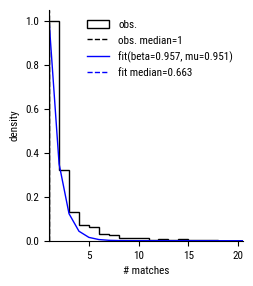

ppm=5.6 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38]
[1.00000000e+00 4.22048540e-01 1.89222542e-01 1.06951872e-01
 7.98025504e-02 4.89510490e-02 4.48375154e-02 3.04401481e-02
 3.00287947e-02 2.67379679e-02 1.23406006e-02 1.35746606e-02
 9.04977376e-03 8.63842040e-03 6.58165364e-03 5.75894694e-03
 2.87947347e-03 0.00000000e+00 3.70218017e-03 2.87947347e-03
 1.23406006e-03 4.52488688e-03 2.46812012e-03 8.22706705e-04
 2.87947347e-03 0.00000000e+00 4.11353353e-04 4.11353353e-04
 4.11353353e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.22706705e-04 4.11353353e-04
 0.00000000e+00 4.11353353e-04]


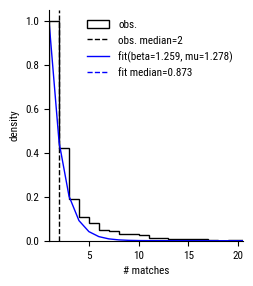

ppm=10.0 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[1.         0.23751687 0.0734143  0.03670715 0.0197031  0.01808367
 0.00512821 0.00512821 0.00134953 0.         0.00134953 0.
 0.         0.         0.00134953]


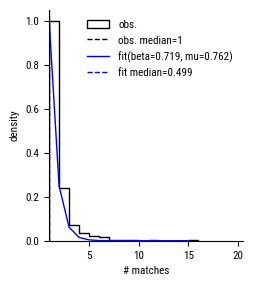

ppm=10.0 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[1.         0.28148596 0.11688312 0.0576865  0.03745092 0.02748414
 0.0154032  0.00996678 0.00543642 0.00302024 0.00271821 0.00392631
 0.00271821 0.         0.00211416]


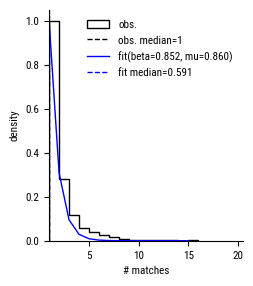

ppm=10.0 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
[1.00000000e+00 3.44522968e-01 1.65371025e-01 9.04593640e-02
 6.53710247e-02 4.06360424e-02 4.45229682e-02 2.01413428e-02
 9.54063604e-03 1.76678445e-02 6.36042403e-03 6.36042403e-03
 2.82685512e-03 2.47349823e-03 6.00706714e-03 2.12014134e-03
 2.82685512e-03 3.53356890e-04 7.06713781e-04 1.76678445e-03
 1.06007067e-03 1.41342756e-03]


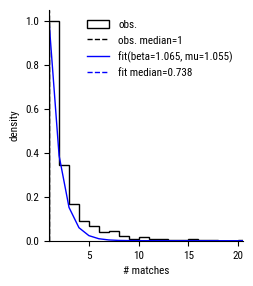

ppm=10.0 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35]
[1.00000000e+00 4.30835118e-01 2.18843683e-01 1.36188437e-01
 1.00642398e-01 6.03854390e-02 6.33832976e-02 4.15417559e-02
 4.23982869e-02 2.65524625e-02 2.44111349e-02 1.84154176e-02
 6.42398287e-03 6.42398287e-03 1.07066381e-02 5.13918630e-03
 1.28479657e-03 1.28479657e-03 1.71306210e-03 1.28479657e-03
 8.56531049e-04 1.02783726e-02 2.99785867e-03 2.14132762e-03
 0.00000000e+00 0.00000000e+00 3.42612420e-03 0.00000000e+00
 8.56531049e-04 0.00000000e+00 0.00000000e+00 4.28265525e-04
 4.28265525e-04 8.56531049e-04 8.56531049e-04]


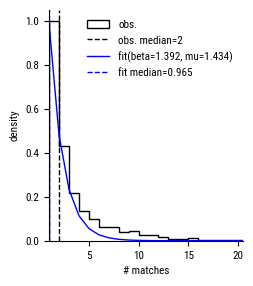

ppm=17.8 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[1.00000000e+00 2.47302669e-01 1.00511073e-01 4.23055082e-02
 2.07268597e-02 1.27768313e-02 6.53038047e-03 4.25894378e-03
 1.13571834e-03 8.51788756e-04 1.13571834e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.67859171e-04]


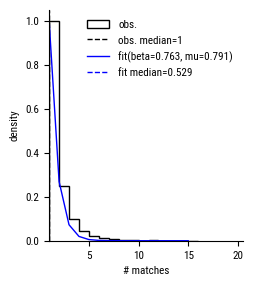

ppm=17.8 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[1.00000000e+00 3.17972350e-01 1.55365372e-01 7.40618828e-02
 4.97037525e-02 2.40289664e-02 1.61290323e-02 7.57077024e-03
 5.92495063e-03 4.93745885e-03 2.96247531e-03 3.94996708e-03
 2.30414747e-03 6.58327847e-04 9.87491771e-04 6.58327847e-04]


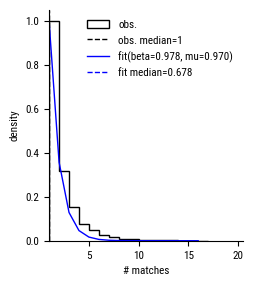

ppm=17.8 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
[1.00000000e+00 4.16231418e-01 2.21775814e-01 1.18119727e-01
 8.07553234e-02 5.54439534e-02 4.90156689e-02 1.92848534e-02
 1.56689434e-02 1.68742467e-02 8.03535556e-03 6.02651667e-03
 4.41944556e-03 7.63358779e-03 3.61591000e-03 2.81237445e-03
 2.00883889e-03 2.00883889e-03 8.03535556e-04 2.00883889e-03
 1.60707111e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.03535556e-04]


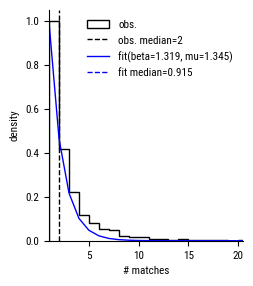

ppm=17.8 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36]
[1.         0.53108535 0.32718651 0.20073762 0.14278188 0.0995785
 0.09167545 0.04425711 0.04478398 0.03424658 0.03003161 0.02897787
 0.01527924 0.01159115 0.01844046 0.01369863 0.00263435 0.00105374
 0.00316122 0.00368809 0.00105374 0.00316122 0.00368809 0.00421496
 0.00158061 0.00105374 0.00210748 0.00105374 0.         0.00368809
 0.         0.         0.00105374 0.         0.         0.00105374]


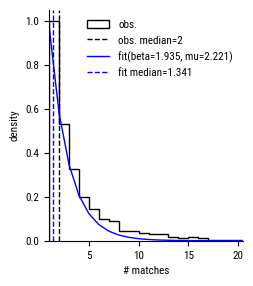

ppm=31.6 tol=0.08
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[1.00000000e+00 3.17945582e-01 1.25038215e-01 5.50290431e-02
 2.78202385e-02 1.83430144e-02 7.03148884e-03 3.05716906e-03
 1.52858453e-03 9.17150718e-04 1.83430144e-03 0.00000000e+00
 3.05716906e-04 0.00000000e+00 1.22286762e-03]


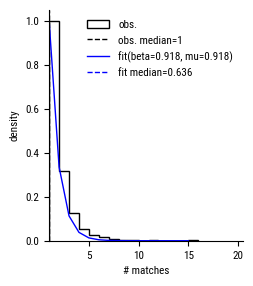

ppm=31.6 tol=0.16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[1.00000000e+00 4.11239300e-01 2.02456271e-01 1.23930033e-01
 5.84294753e-02 4.46594715e-02 2.15854112e-02 1.30256792e-02
 5.58243394e-03 2.23297358e-03 4.09378489e-03 4.83810942e-03
 4.83810942e-03 3.72162263e-04 1.48864905e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.72162263e-04]


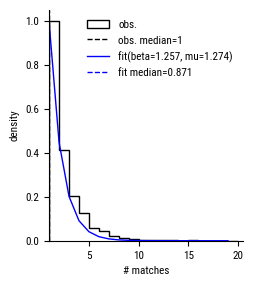

ppm=31.6 tol=0.32
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]
[1.00000000e+00 5.48262548e-01 2.90057915e-01 1.84362934e-01
 1.27895753e-01 9.07335907e-02 7.72200772e-02 4.82625483e-02
 2.46138996e-02 1.68918919e-02 1.06177606e-02 1.20656371e-02
 4.34362934e-03 6.27413127e-03 5.79150579e-03 1.44787645e-03
 6.27413127e-03 2.41312741e-03 4.82625483e-04 9.65250965e-04
 0.00000000e+00 1.93050193e-03 0.00000000e+00 4.82625483e-04
 0.00000000e+00 0.00000000e+00 1.44787645e-03]


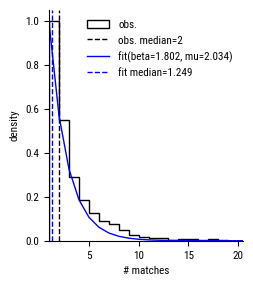

ppm=31.6 tol=0.64
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[1.00000000e+00 6.79638638e-01 4.75330090e-01 3.05072967e-01
 2.61987491e-01 1.72341904e-01 1.44544823e-01 1.02849201e-01
 7.43571925e-02 7.64419736e-02 5.69840167e-02 3.82209868e-02
 2.71021543e-02 2.29325921e-02 2.64072272e-02 1.38985407e-02
 1.18137596e-02 9.72897846e-03 4.86448923e-03 3.47463516e-03
 6.94927033e-03 1.04239055e-02 4.16956220e-03 6.94927033e-04
 2.08478110e-03 1.38985407e-03 0.00000000e+00 0.00000000e+00
 1.38985407e-03 4.16956220e-03 6.94927033e-04 6.94927033e-04
 0.00000000e+00 2.08478110e-03 1.38985407e-03 6.94927033e-04
 0.00000000e+00 6.94927033e-04 6.94927033e-04]


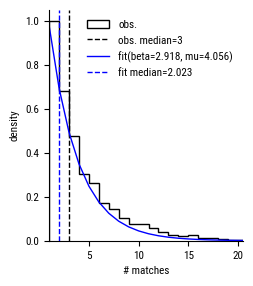

src_ids=(366, 367)
ppm=0.6 tol=0.2
[1 2 3]
[1.         0.0567546  0.00479616]


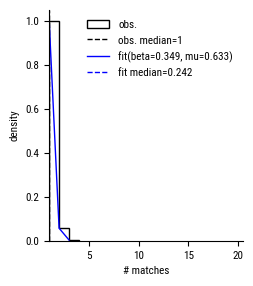

ppm=0.6 tol=0.4
[1 2 3 4 5]
[1.         0.10202361 0.01264755 0.00337268 0.00168634]


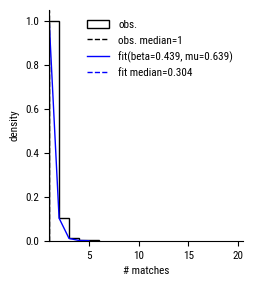

ppm=0.6 tol=0.8
[1 2 3 4 5]
[1.         0.14605735 0.02688172 0.01344086 0.00358423]


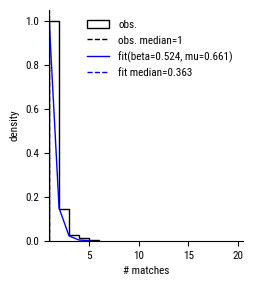

ppm=0.6 tol=1.6
[1 2 3 4 5 6]
[1.         0.16525024 0.0509915  0.02455146 0.01133144 0.00188857]


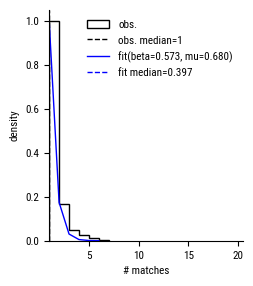

ppm=1.0 tol=0.2
[1 2 3]
[1.         0.06481481 0.00462963]


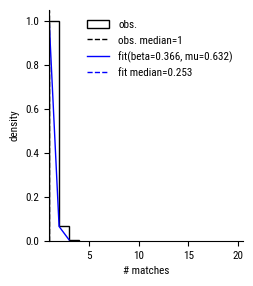

ppm=1.0 tol=0.4
[1 2 3 4]
[1.         0.11101974 0.02384868 0.00493421]


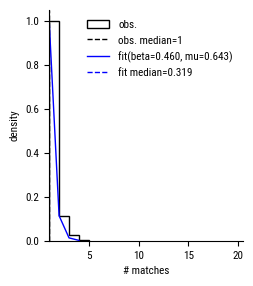

ppm=1.0 tol=0.8
[1 2 3 4]
[1.         0.13431542 0.04766031 0.01906412]


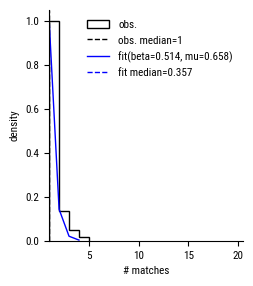

ppm=1.0 tol=1.6
[1 2 3 4 5 6]
[1.         0.16090909 0.04454545 0.03909091 0.01363636 0.00181818]


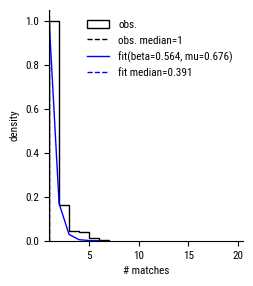

ppm=1.8 tol=0.2
[1 2 3]
[1.         0.05725806 0.00725806]


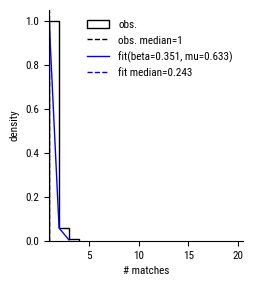

ppm=1.8 tol=0.4
[1 2 3 4]
[1.         0.09812287 0.02133106 0.00682594]


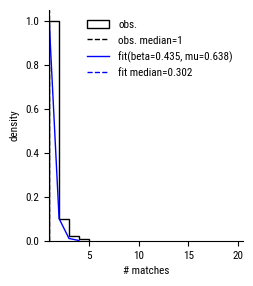

ppm=1.8 tol=0.8
[1 2 3 4 5 6]
[1.         0.13805631 0.0417802  0.01725704 0.         0.00181653]


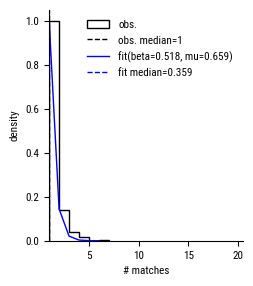

ppm=1.8 tol=1.6
[1 2 3 4 5 6]
[1.         0.20672601 0.03560831 0.04451039 0.0148368  0.00395648]


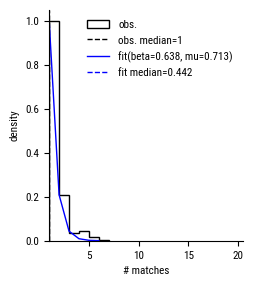

ppm=3.2 tol=0.2
[1 2 3]
[1.         0.07606973 0.01426307]


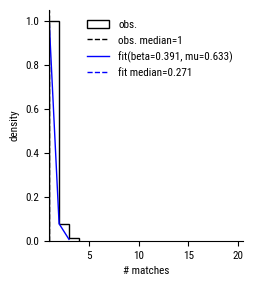

ppm=3.2 tol=0.4
[1 2 3 4]
[1.         0.11973019 0.03204047 0.0084317 ]


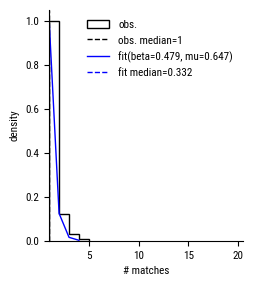

ppm=3.2 tol=0.8
[1 2 3 4 5 6]
[1.         0.16366906 0.04406475 0.02517986 0.00269784 0.00179856]


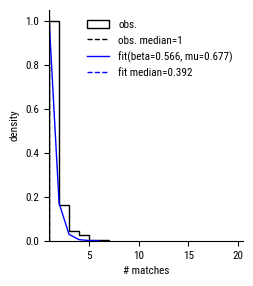

ppm=3.2 tol=1.6
[1 2 3 4 5 6 7]
[1.         0.20465567 0.07371484 0.03685742 0.01357905 0.00387973
 0.00193986]


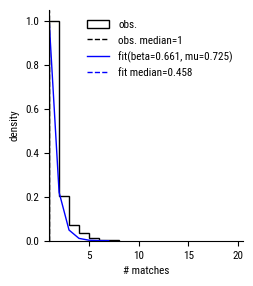

ppm=5.6 tol=0.2
[1 2 3 4]
[1.         0.06860371 0.00968523 0.00161421]


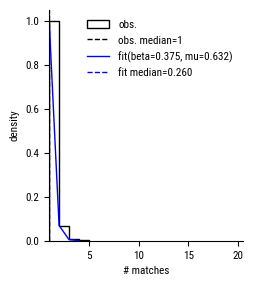

ppm=5.6 tol=0.4
[1 2 3 4 5]
[1.         0.13391304 0.02086957 0.00695652 0.00173913]


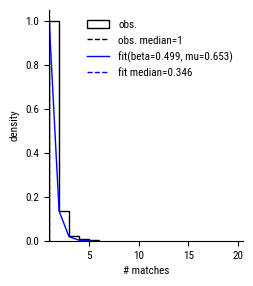

ppm=5.6 tol=0.8
[1 2 3 4 5 6]
[1.         0.1774043  0.05322129 0.0140056  0.00280112 0.00186741]


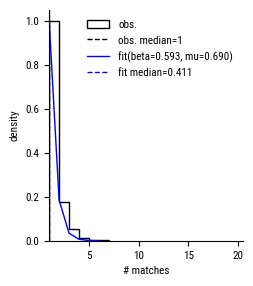

ppm=5.6 tol=1.6
[1 2 3 4 5 6 7 8 9]
[1.         0.23595506 0.07456588 0.03677222 0.01327886 0.00306435
 0.         0.00102145 0.0020429 ]


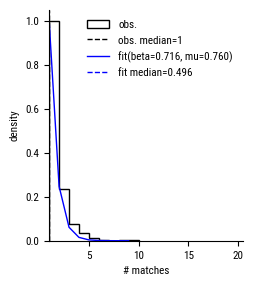

ppm=10.0 tol=0.2
[1 2 3 4]
[1.         0.09200969 0.00968523 0.00161421]


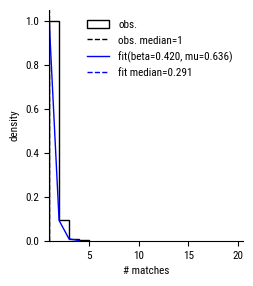

ppm=10.0 tol=0.4
[1 2 3 4 5]
[1.         0.13137424 0.03284356 0.01382887 0.00345722]


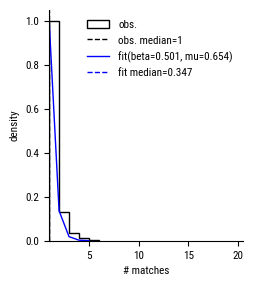

ppm=10.0 tol=0.8
[1 2 3 4 5 6]
[1.         0.21223709 0.0583174  0.02294455 0.00860421 0.00478011]


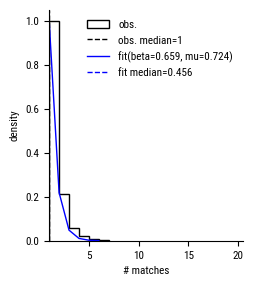

ppm=10.0 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11]
[1.         0.29836066 0.09945355 0.04262295 0.03060109 0.01311475
 0.00546448 0.         0.00218579 0.         0.00218579]


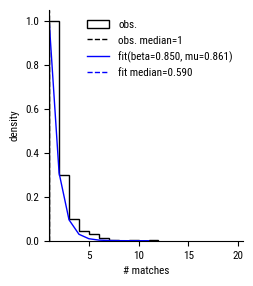

ppm=17.8 tol=0.2
[1 2 3]
[1.         0.08527132 0.01162791]


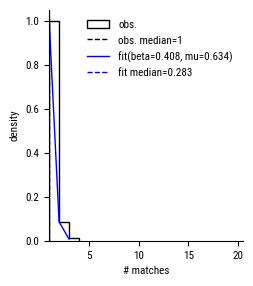

ppm=17.8 tol=0.4
[1 2 3 4 5]
[1.         0.15914894 0.02468085 0.01531915 0.00510638]


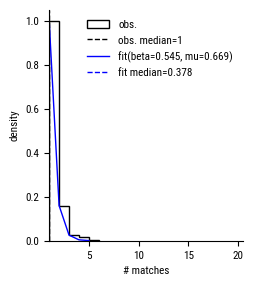

ppm=17.8 tol=0.8
[1 2 3 4 5 6]
[1.         0.20712277 0.06373008 0.03280225 0.01593252 0.00656045]


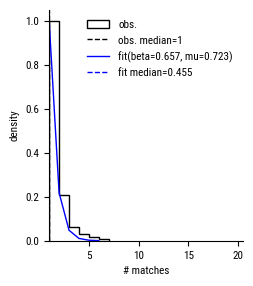

ppm=17.8 tol=1.6
[ 1  2  3  4  5  6  7  8  9 10 11]
[1.         0.30290011 0.09989259 0.06766917 0.02255639 0.01181525
 0.01074114 0.         0.00214823 0.         0.00214823]


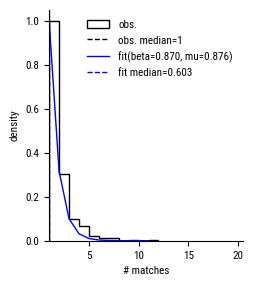

ppm=31.6 tol=0.2
[1 2 3 4]
[1.         0.11596639 0.01764706 0.00504202]


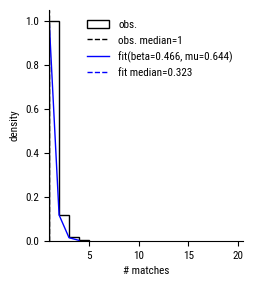

ppm=31.6 tol=0.4
[1 2 3 4 5]
[1.         0.1704649  0.03919781 0.02005469 0.00546946]


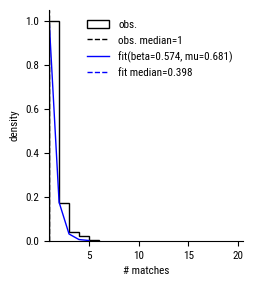

ppm=31.6 tol=0.8
[1 2 3 4 5 6 7]
[1.         0.27679501 0.06867846 0.03225806 0.01977107 0.00416233
 0.00832466]


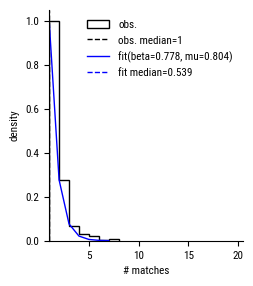

ppm=31.6 tol=1.6
[1 2 3 4 5 6 7 8 9]
[1.         0.42911877 0.16347382 0.06002554 0.02681992 0.02426564
 0.02171137 0.00255428 0.00255428]


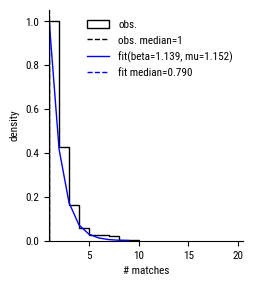

src_ids=(260, 261)
ppm=0.6 tol=0.25
[1 2 3 4 5]
[1.         0.0993865  0.02453988 0.00613497 0.00122699]


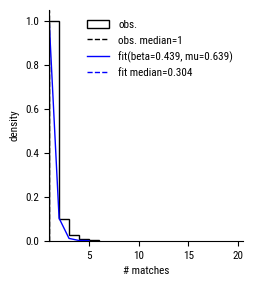

ppm=0.6 tol=0.5
[1 2 3 4 5]
[1.         0.10148515 0.02970297 0.00866337 0.00123762]


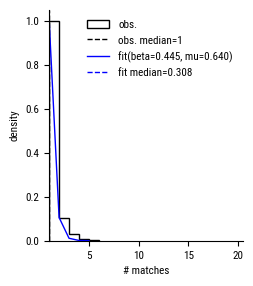

ppm=0.6 tol=1.0
[1 2 3 4 5]
[1.         0.11913815 0.03422053 0.0139417  0.00126743]


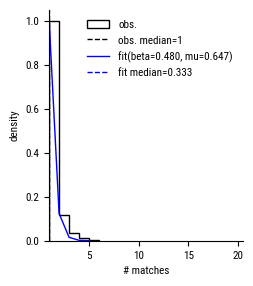

ppm=0.6 tol=2.0
[1 2 3 4 5]
[1.         0.15131579 0.04605263 0.01447368 0.00131579]


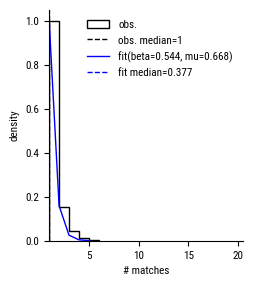

ppm=1.0 tol=0.25
[1 2 3 4 5]
[1.         0.08530806 0.02132701 0.00592417 0.00118483]


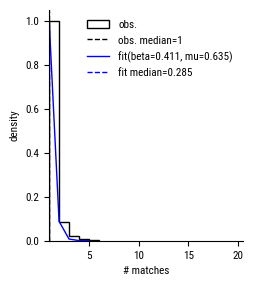

ppm=1.0 tol=0.5
[1 2 3 4 5]
[1.         0.10827251 0.02554745 0.00851582 0.00121655]


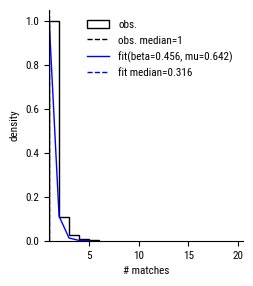

ppm=1.0 tol=1.0
[1 2 3 4 5]
[1.         0.12484395 0.02871411 0.01872659 0.00124844]


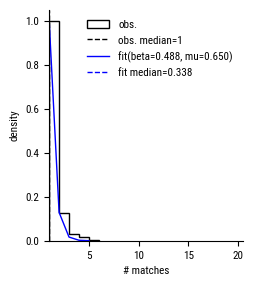

ppm=1.0 tol=2.0
[1 2 3 4 5]
[1.         0.13554987 0.04603581 0.01918159 0.00127877]


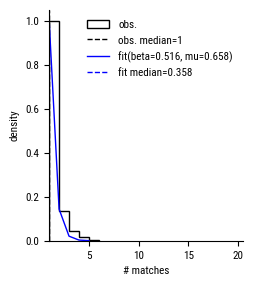

ppm=1.8 tol=0.25
[1 2 3 4]
[1.         0.13861386 0.03094059 0.00742574]


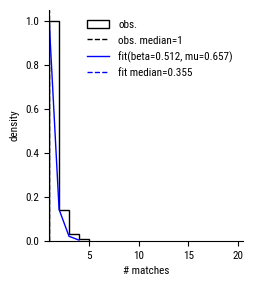

ppm=1.8 tol=0.5
[1 2 3 4]
[1.         0.16010165 0.03811944 0.01016518]


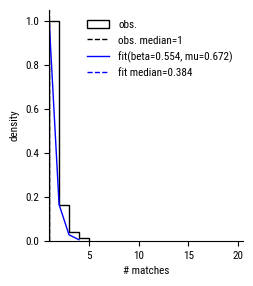

ppm=1.8 tol=1.0
[1 2 3 4]
[1.         0.17385621 0.04575163 0.02352941]


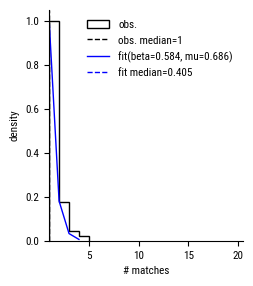

ppm=1.8 tol=2.0
[1 2 3 4]
[1.         0.21244926 0.04871448 0.02571042]


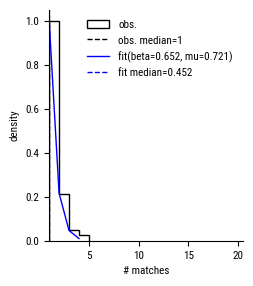

ppm=3.2 tol=0.25
[1 2 3 4]
[1.         0.13821138 0.02439024 0.0058072 ]


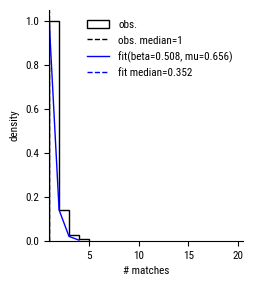

ppm=3.2 tol=0.5
[1 2 3 4]
[1.         0.1567696  0.02731591 0.01068884]


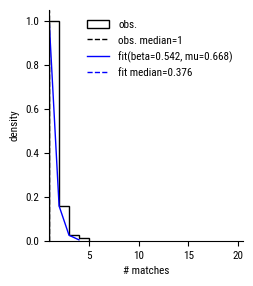

ppm=3.2 tol=1.0
[1 2 3 4]
[1.      0.2     0.04125 0.01625]


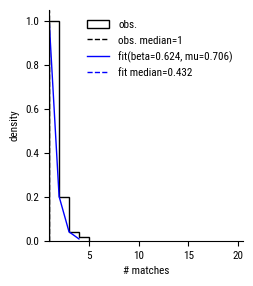

ppm=3.2 tol=2.0
[1 2 3 4]
[1.         0.24540682 0.05774278 0.01706037]


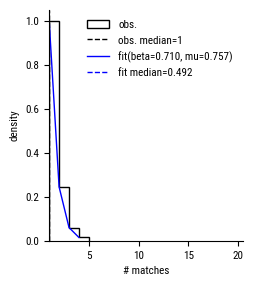

ppm=5.6 tol=0.25
[1 2 3 4]
[1.         0.15322581 0.03629032 0.00672043]


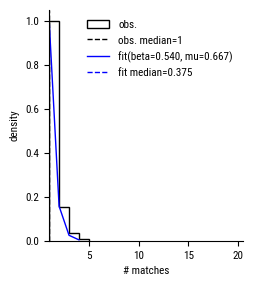

ppm=5.6 tol=0.5
[1 2 3 4 5 6]
[1.         0.16620879 0.04945055 0.00412088 0.00137363 0.00137363]


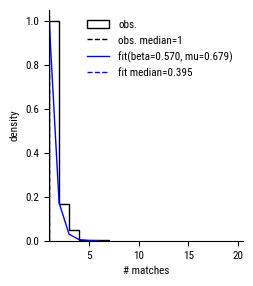

ppm=5.6 tol=1.0
[1 2 3 4 5 6]
[1.         0.19170243 0.07010014 0.00858369 0.00143062 0.00143062]


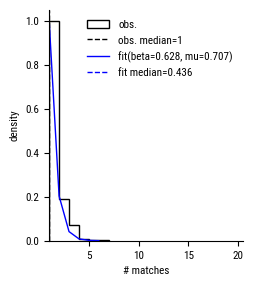

ppm=5.6 tol=2.0
[1 2 3 4 5 6]
[1.         0.23168909 0.08370703 0.01195815 0.00149477 0.00149477]


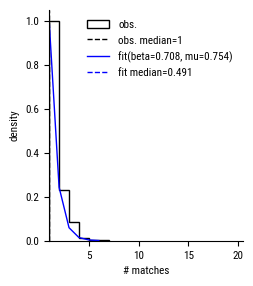

ppm=10.0 tol=0.25
[1 2 3 4 5 6]
[1.         0.14197531 0.05802469 0.00493827 0.0037037  0.00123457]


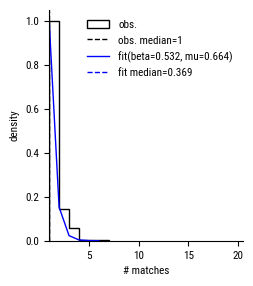

ppm=10.0 tol=0.5
[1 2 3 4 5 6]
[1.         0.17692308 0.06923077 0.00384615 0.00512821 0.00128205]


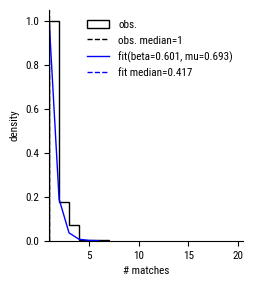

ppm=10.0 tol=1.0
[1 2 3 4 5 6]
[1.         0.23809524 0.08163265 0.00680272 0.00544218 0.00136054]


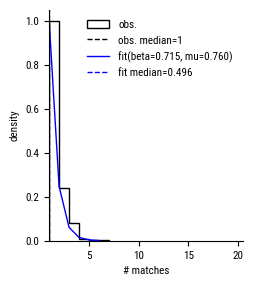

ppm=10.0 tol=2.0
[1 2 3 4 5 6]
[1.         0.31104651 0.08430233 0.01453488 0.0130814  0.00145349]


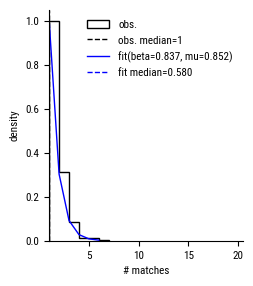

ppm=17.8 tol=0.25
[1 2 3 4 5]
[1.         0.13411765 0.03176471 0.00705882 0.00117647]


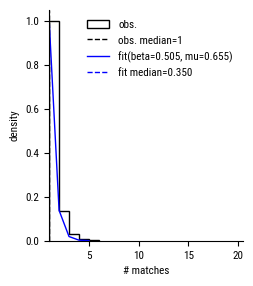

ppm=17.8 tol=0.5
[1 2 3 4 5 6]
[1.         0.17139334 0.04685573 0.00863132 0.00246609 0.00123305]


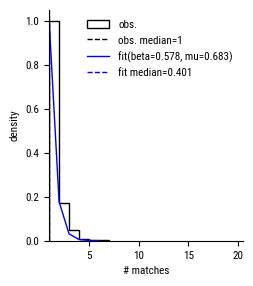

ppm=17.8 tol=1.0
[1 2 3 4 5 6]
[1.         0.21704394 0.07456724 0.03062583 0.00532623 0.00133156]


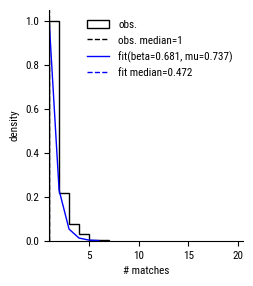

ppm=17.8 tol=2.0
[1 2 3 4 5 6]
[1.         0.29883382 0.08746356 0.05393586 0.01311953 0.00145773]


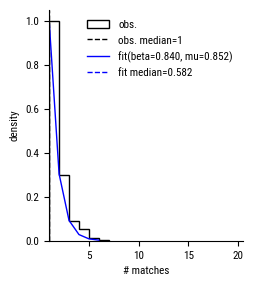

ppm=31.6 tol=0.25
[1 2 3 4 5 6]
[1.         0.16067146 0.0323741  0.01079137 0.00359712 0.00119904]


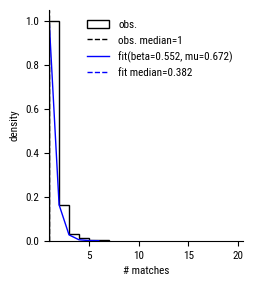

ppm=31.6 tol=0.5
[1 2 3 4 5 6]
[1.         0.21711367 0.04853129 0.01149425 0.00510856 0.00510856]


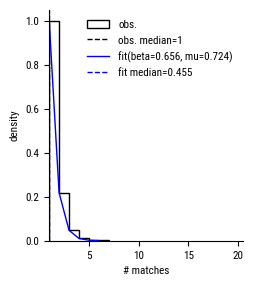

ppm=31.6 tol=1.0
[1 2 3 4 5 6 7 8]
[1.         0.28391608 0.07692308 0.03216783 0.00699301 0.00699301
 0.         0.0027972 ]


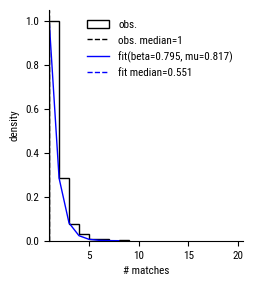

ppm=31.6 tol=2.0
[1 2 3 4 5 6 7 8]
[1.         0.3640553  0.10445469 0.05376344 0.01228879 0.01075269
 0.         0.0030722 ]


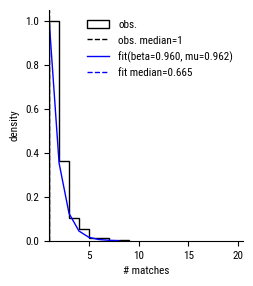

In [19]:
# keep track of fit parameters and summary stats
ppms, tols = {}, {}
betas, mus, obs_meds = {}, {}, {}
for src_ids, rt_tols in RT_TOLERANCES.items():
    print(f"{src_ids=}")
    ppms[src_ids] = []
    tols[src_ids] = []
    betas[src_ids] = []
    mus[src_ids] = []
    obs_meds[src_ids] = []
    for ppm in MZ_PPMS:
        for tol in rt_tols:
            ppms[src_ids].append(ppm)
            tols[src_ids].append(tol)
            print(f"{ppm=} {tol=}")
            fig, ax = plt.subplots(figsize=(2.5, 3))
            bin_max = max(mz_rt_probs[src_ids][(ppm, tol)]) + 2
            c, x = np.histogram(mz_rt_probs[src_ids][(ppm, tol)], np.arange(1, bin_max))
            cn = c / max(c)
            ax.hist(mz_rt_probs[src_ids][(ppm, tol)], bins=np.arange(1, bin_max), color="k", histtype="step", lw=1., 
                    weights=[1 / max(c)] * len(mz_rt_probs[src_ids][(ppm, tol)]), label="obs.") 
            obs_med = np.median(mz_rt_probs[src_ids][(ppm, tol)])
            ax.axvline(obs_med, ls="--", lw=1., label=f"obs. median={obs_med:.0f}", c="k")
            print(x[:-1])
            print(cn)
            (beta, mu), _ = optimize.curve_fit(fexp, x[:-1], cn)
            ax.plot(x[:-1], fexp(x[:-1], beta, mu), 'b-', lw=1., label=f"fit({beta=:.3f}, {mu=:.3f})")
            fit_med = beta * np.log(2.)
            ax.axvline(fit_med, ls="--", lw=1., label=f"fit median={fit_med:.3f}", c="b")
            ax.legend(frameon=False)
            for d in ["top", "right"]:
                ax.spines[d].set_visible(False)
            #ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
            ax.set_xlabel("# matches")
            ax.set_ylabel("density")
            ax.set_xlim([1, 20 + 0.5])
            plt.savefig(f"_figures/mz_rt/{"-".join([str(_) for _ in src_ids])}_{ppm=}_{tol=}_dist_with_fit.png", 
                        dpi=400, bbox_inches="tight")
            plt.show()
            plt.close()
            betas[src_ids].append(beta)
            mus[src_ids].append(mu)
            obs_meds[src_ids].append(obs_med)

fit_meds = {
    src_ids: [_ * np.log(2) for _ in betas[src_ids]]
    for src_ids in [(408,), (186,), (374, 375), (366, 367), (260, 261)]
}

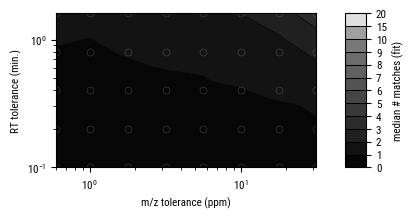

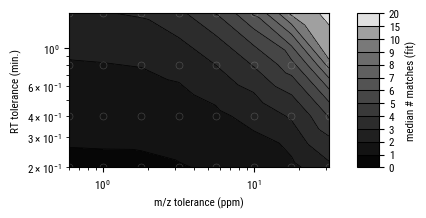

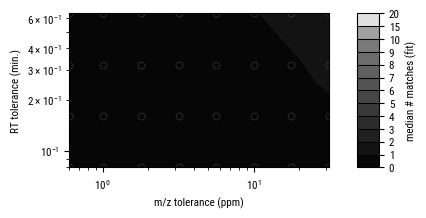

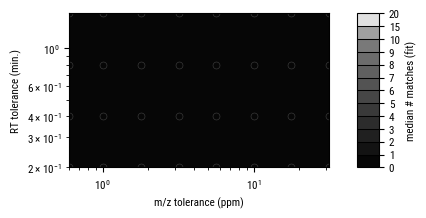

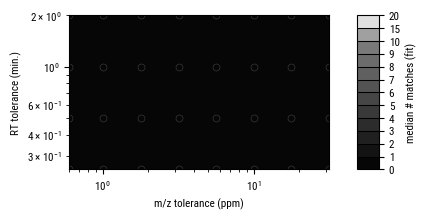

In [20]:
for src_ids, rt_tols in RT_TOLERANCES.items():
    fig, (ax, axcb) = plt.subplots(ncols=2, width_ratios=(12, 1), figsize=(4, 2))
    mz_bins = MZ_PPMS + [56]
    rt_bins = rt_tols + RT_TOLERANCES_EXTRA[src_ids]
    levels = [_ for _ in range(10)] + [10, 15, 20]
    tcf = ax.tricontourf(ppms[src_ids], tols[src_ids], fit_meds[src_ids], levels, cmap="binary_r")
    ax.tricontour(ppms[src_ids], tols[src_ids], fit_meds[src_ids], levels, colors="k", linewidths=0.5)
    ax.plot(ppms[src_ids], tols[src_ids], "wo", ms=5, fillstyle="none", mew=0.5, alpha=0.2)
    ax.set_xlabel("m/z tolerance (ppm)")
    ax.set_ylabel("RT tolerance (min.)")
    ax.set_xscale("log")
    ax.set_yscale("log")
    cb = fig.colorbar(tcf, cax=axcb)
    cb.set_ticks(levels)
    cb.set_ticklabels(levels)
    for l in levels[1:-1]:
        cb.ax.axhline(l, lw=0.75, c="k")
    cb.set_label("median # matches (fit)")
    plt.savefig(f"_figures/mz_rt/{"-".join([str(_) for _ in src_ids])}_2D_tolerance_contour.png", 
                dpi=400, bbox_inches="tight")
    plt.show()
    plt.close()

In [ ]:
(min(fit_meds), max(fit_meds))

# m/z + MS2

## Initialize and Cache

In [8]:
mz_ms2 = {"mz_ms2_probs": {}, "mzs": {}}

In [9]:
db = IdPPdb("idpp_cleaned_expanded.db", read_only=True, enforce_idpp_ver=False)

for i in range(5):
    random.seed(i + 130)
    for ppm in MZ_PPMS:
        print(f"{ppm=}")
        selected = 0
        for i, (id_A, matched_A) in enumerate(mz_results[ppm].items()):
            if random.random() > 0.005:
                # most of the time just skip
                continue
            selected += 1
            #print("---")
            #print(f"{id_A=} {matched_A=}")
            aid_A = cmpd_id_to_adduct_id[id_A]
            #print(f"{aid_A=}")
            # id_A is a compound ID, need to convert to adduct ID(s) then use that(those) to
            # create an MS2Tree on the fly for matches to this compound
            matched_aids = set([aid for cid in matched_A for aid in cmpd_id_to_adduct_id[cid]])
            #print(f"{matched_aids=}")
            try:
                if (ms2t := construct_ms2_tree_for_adduct_ids(db, matched_aids)) is not None:
                    for tol in MS2_TOLERANCES:
                        #print(f"{tol=}")
                        qres = ms2t.query_all(tol)
                        #print(f"{qres=}")
                        q_aids = set()
                        for aid_A in cmpd_id_to_adduct_id[id_A]:
                            if aid_A in qres:
                                q_aids |= qres[aid_A]
                        if len(q_aids) > 0:
                            #print(f"{q_aids=}")
                            common_aids = matched_aids & q_aids
                            common_cids = set([ms2t.adduct_to_cmpd_id[aid] for aid in common_aids])
                            #print(f"{common_aids=}")
                            #print(f"{common_cids=}")
                            n = len(common_cids)
                            m = len(matched_A)
                            #print(f"{n=} {m=}")
                            k = (ppm, tol)
                            if k in mz_ms2["mz_ms2_probs"]:
                                mz_ms2["mz_ms2_probs"][k].append(n)
                            else:
                                mz_ms2["mz_ms2_probs"][k] = [n]
                            if k in mz_ms2["mzs"]:
                                mz_ms2["mzs"][k].append(m)
                            else:
                                mz_ms2["mzs"][k] = [m]
                print(f"\rsampled {selected} of {i + 1}  ({100 * (selected / (i + 1)):.1f} %)", end="    ")
            except KeyboardInterrupt:
                break
            except:
                continue
        print()
        # cache the results after each ppm completes
        with open("_cache/mz_ms2.pkl", "wb") as pf:
            pickle.dump(mz_ms2, pf)

db.close()

ppm=0.6
sampled 1009 of 198844  (0.5 %)    
ppm=1.0
sampled 996 of 198723  (0.5 %)    
ppm=1.8
sampled 909 of 198833  (0.5 %)    
ppm=3.2
sampled 1002 of 198815  (0.5 %)    
ppm=5.6
sampled 975 of 198850  (0.5 %)    
ppm=10.0
sampled 1015 of 198347  (0.5 %)    
ppm=17.8
sampled 1027 of 198876  (0.5 %)    
ppm=31.6
sampled 1026 of 198748  (0.5 %)    
ppm=0.6
sampled 989 of 198857  (0.5 %)    
ppm=1.0
sampled 1039 of 198856  (0.5 %)    
ppm=1.8
sampled 1006 of 198632  (0.5 %)    
ppm=3.2
sampled 995 of 198698  (0.5 %)    
ppm=5.6
sampled 987 of 198763  (0.5 %)    
ppm=10.0
sampled 1016 of 198867  (0.5 %)    
ppm=17.8
sampled 974 of 198819  (0.5 %)    
ppm=31.6
sampled 962 of 198859  (0.5 %)    
ppm=0.6
sampled 1017 of 198410  (0.5 %)    
ppm=1.0
sampled 993 of 198704  (0.5 %)    
ppm=1.8
sampled 989 of 198872  (0.5 %)    
ppm=3.2
sampled 986 of 198104  (0.5 %)    
ppm=5.6
sampled 1045 of 198892  (0.5 %)    
ppm=10.0
sampled 989 of 198714  (0.5 %)    
ppm=17.8
sampled 1027 of 198635  (0.5

In [10]:
db = IdPPdb("idpp_cleaned_expanded.db", read_only=True, enforce_idpp_ver=False)

for i in range(5):
    random.seed(i + 150)
    for ppm in MZ_PPMS:
        print(f"{ppm=}")
        selected = 0
        for i, (id_A, matched_A) in enumerate(mz_results[ppm].items()):
            if random.random() > 0.005:
                # most of the time just skip
                continue
            selected += 1
            #print("---")
            #print(f"{id_A=} {matched_A=}")
            aid_A = cmpd_id_to_adduct_id[id_A]
            #print(f"{aid_A=}")
            # id_A is a compound ID, need to convert to adduct ID(s) then use that(those) to
            # create an MS2Tree on the fly for matches to this compound
            matched_aids = set([aid for cid in matched_A for aid in cmpd_id_to_adduct_id[cid]])
            #print(f"{matched_aids=}")
            try:
                if (ms2t := construct_ms2_tree_for_adduct_ids(db, matched_aids)) is not None:
                    for tol in MS2_TOLERANCES:
                        #print(f"{tol=}")
                        qres = ms2t.query_all(tol)
                        #print(f"{qres=}")
                        q_aids = set()
                        for aid_A in cmpd_id_to_adduct_id[id_A]:
                            if aid_A in qres:
                                q_aids |= qres[aid_A]
                        if len(q_aids) > 0:
                            #print(f"{q_aids=}")
                            common_aids = matched_aids & q_aids
                            common_cids = set([ms2t.adduct_to_cmpd_id[aid] for aid in common_aids])
                            #print(f"{common_aids=}")
                            #print(f"{common_cids=}")
                            n = len(common_cids)
                            m = len(matched_A)
                            #print(f"{n=} {m=}")
                            k = (ppm, tol)
                            if k in mz_ms2["mz_ms2_probs"]:
                                mz_ms2["mz_ms2_probs"][k].append(n)
                            else:
                                mz_ms2["mz_ms2_probs"][k] = [n]
                            if k in mz_ms2["mzs"]:
                                mz_ms2["mzs"][k].append(m)
                            else:
                                mz_ms2["mzs"][k] = [m]
                print(f"\rsampled {selected} of {i + 1}  ({100 * (selected / (i + 1)):.1f} %)", end="    ")
            except KeyboardInterrupt:
                break
            except:
                continue
        print()
        # cache the results after each ppm completes
        with open("_cache/mz_ms2.pkl", "wb") as pf:
            pickle.dump(mz_ms2, pf)

db.close()

ppm=0.6
sampled 1006 of 198718  (0.5 %)    
ppm=1.0
sampled 981 of 198893  (0.5 %)    
ppm=1.8
sampled 1033 of 198234  (0.5 %)    
ppm=3.2
sampled 948 of 198612  (0.5 %)    
ppm=5.6
sampled 1006 of 198596  (0.5 %)    
ppm=10.0
sampled 967 of 198833  (0.5 %)    
ppm=17.8
sampled 989 of 198846  (0.5 %)    
ppm=31.6
sampled 995 of 198573  (0.5 %)    
ppm=0.6
sampled 1024 of 198764  (0.5 %)    
ppm=1.0
sampled 1005 of 198686  (0.5 %)    
ppm=1.8
sampled 1018 of 198583  (0.5 %)    
ppm=3.2
sampled 977 of 198886  (0.5 %)    
ppm=5.6
sampled 1039 of 198727  (0.5 %)    
ppm=10.0
sampled 1005 of 198752  (0.5 %)    
ppm=17.8
sampled 1004 of 198756  (0.5 %)    
ppm=31.6
sampled 940 of 198707  (0.5 %)    
ppm=0.6
sampled 1048 of 198825  (0.5 %)    
ppm=1.0
sampled 942 of 198792  (0.5 %)    
ppm=1.8
sampled 1006 of 198553  (0.5 %)    
ppm=3.2
sampled 1041 of 198854  (0.5 %)    
ppm=5.6
sampled 992 of 198879  (0.5 %)    
ppm=10.0
sampled 979 of 198861  (0.5 %)    
ppm=17.8
sampled 953 of 198824  (0.

In [11]:
# cache the results
with open("_cache/mz_ms2.pkl", "wb") as pf:
    pickle.dump(mz_ms2, pf)

## Load Cached

In [4]:
with open("_cache/mz_ms2.pkl", "rb") as pf:
    mz_ms2 = pickle.load(pf)

## Plots

ppm=0.6 tol=0.99


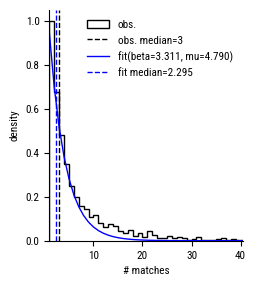

ppm=0.6 tol=0.95


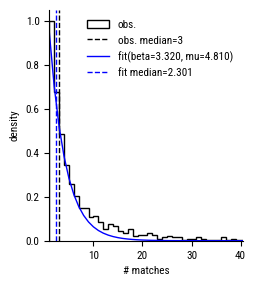

ppm=0.6 tol=0.9


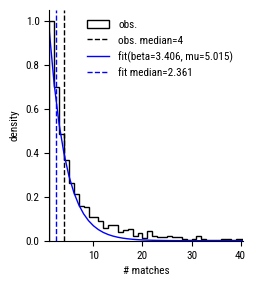

ppm=0.6 tol=0.8


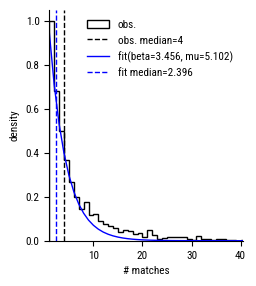

ppm=0.6 tol=0.5


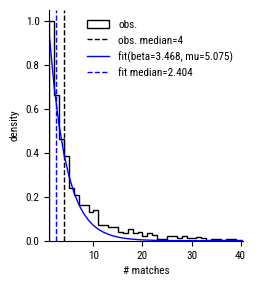

ppm=0.6 tol=0.65


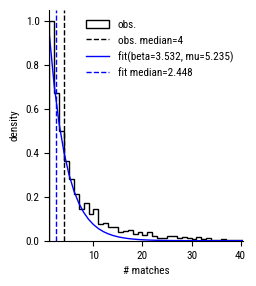

ppm=0.6 tol=0.25


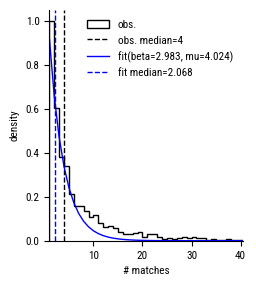

ppm=0.6 tol=0.1


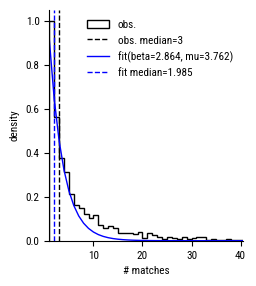

ppm=1.0 tol=0.99


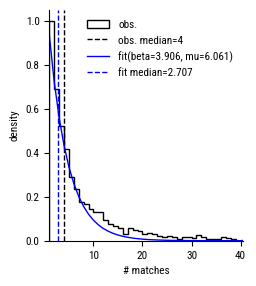

ppm=1.0 tol=0.95


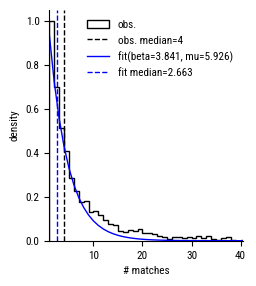

ppm=1.0 tol=0.9


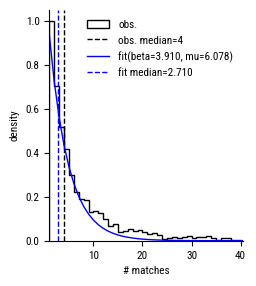

ppm=1.0 tol=0.8


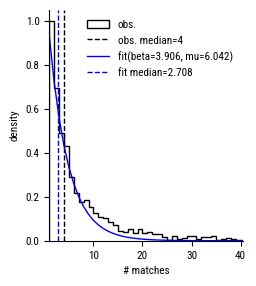

ppm=1.0 tol=0.5


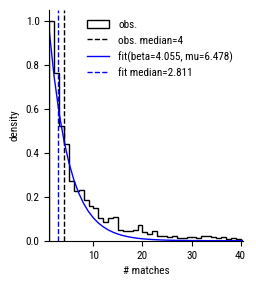

ppm=1.0 tol=0.65


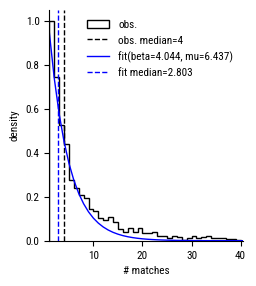

ppm=1.0 tol=0.25


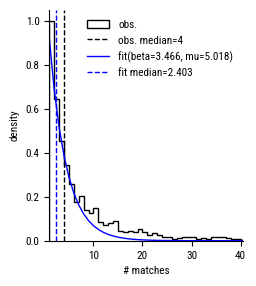

ppm=1.0 tol=0.1


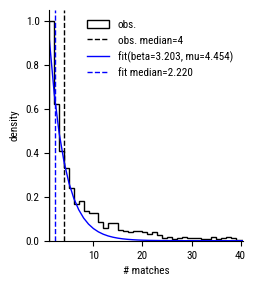

ppm=1.8 tol=0.99


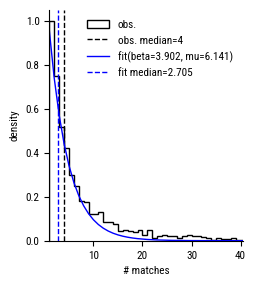

ppm=1.8 tol=0.95


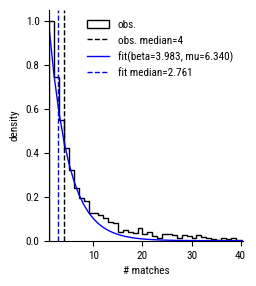

ppm=1.8 tol=0.9


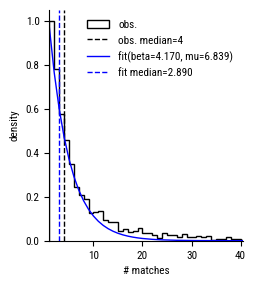

ppm=1.8 tol=0.8


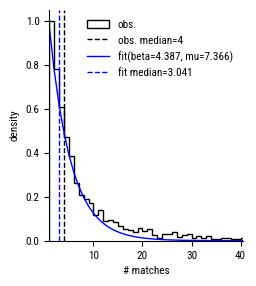

ppm=1.8 tol=0.5


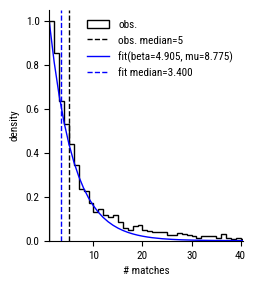

ppm=1.8 tol=0.65


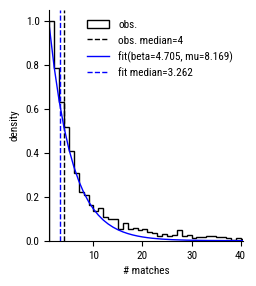

ppm=1.8 tol=0.25


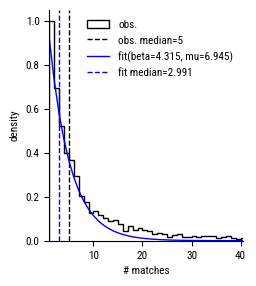

ppm=1.8 tol=0.1


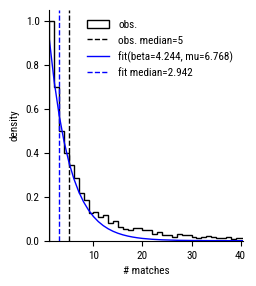

ppm=3.2 tol=0.99


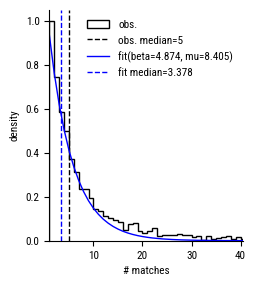

ppm=3.2 tol=0.95


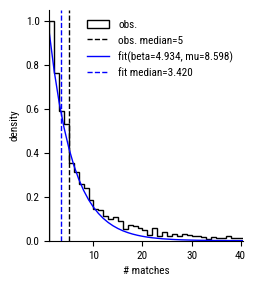

ppm=3.2 tol=0.9


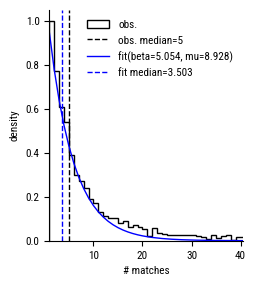

ppm=3.2 tol=0.8


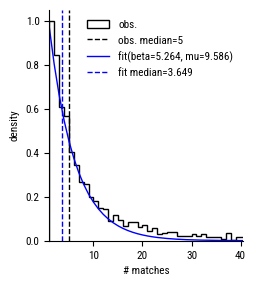

ppm=3.2 tol=0.5


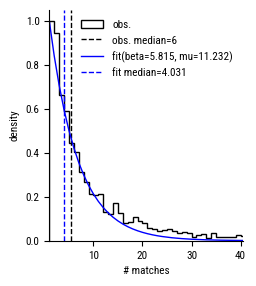

ppm=3.2 tol=0.65


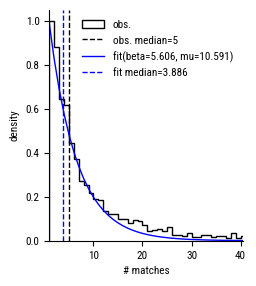

ppm=3.2 tol=0.25


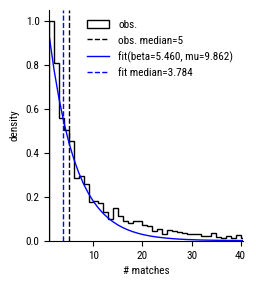

ppm=3.2 tol=0.1


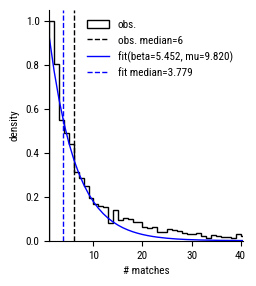

ppm=5.6 tol=0.99


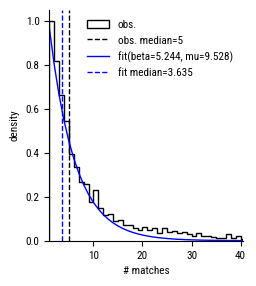

ppm=5.6 tol=0.95


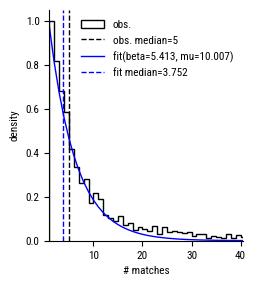

ppm=5.6 tol=0.9


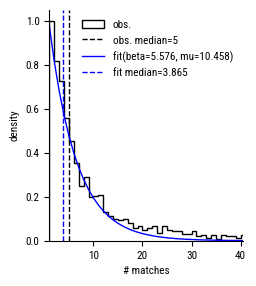

ppm=5.6 tol=0.8


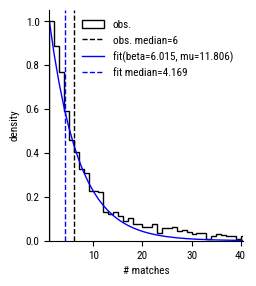

ppm=5.6 tol=0.5


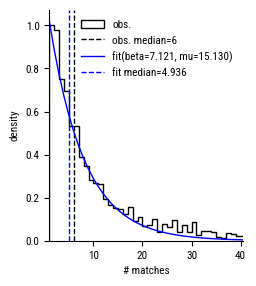

ppm=5.6 tol=0.65


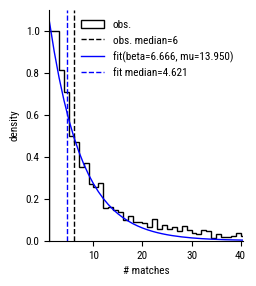

ppm=5.6 tol=0.25


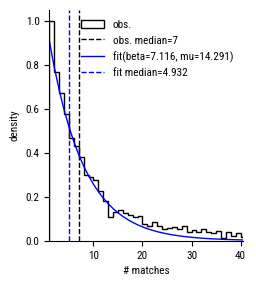

ppm=5.6 tol=0.1


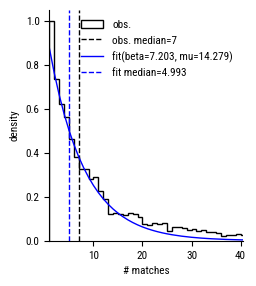

ppm=10.0 tol=0.99


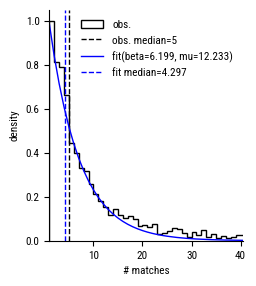

ppm=10.0 tol=0.95


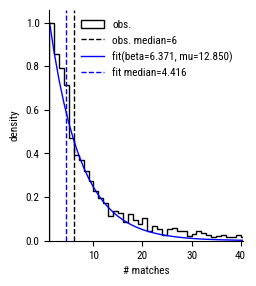

ppm=10.0 tol=0.9


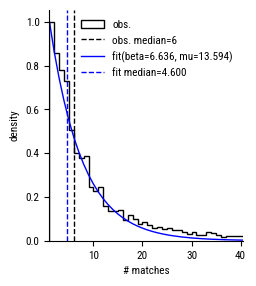

ppm=10.0 tol=0.8


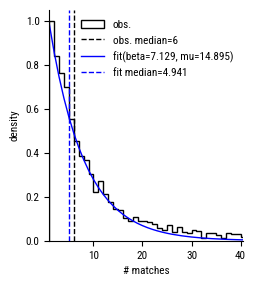

ppm=10.0 tol=0.5


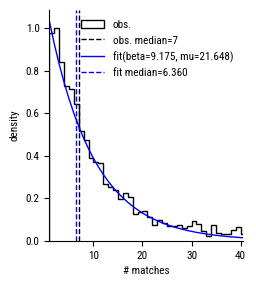

ppm=10.0 tol=0.65


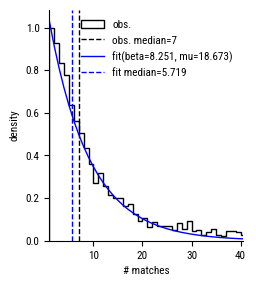

ppm=10.0 tol=0.25


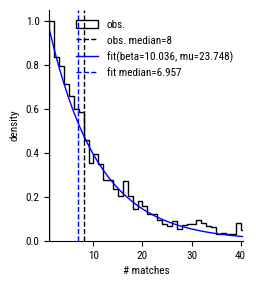

ppm=10.0 tol=0.1


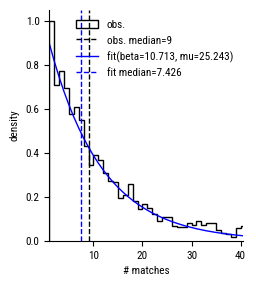

ppm=17.8 tol=0.99


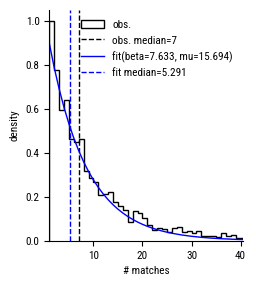

ppm=17.8 tol=0.95


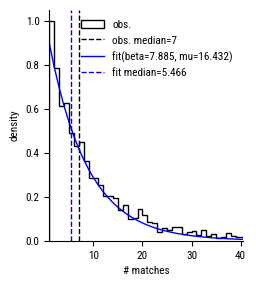

ppm=17.8 tol=0.9


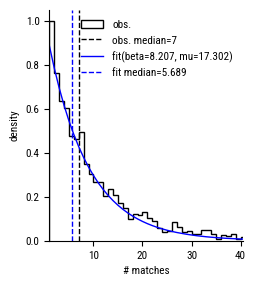

ppm=17.8 tol=0.8


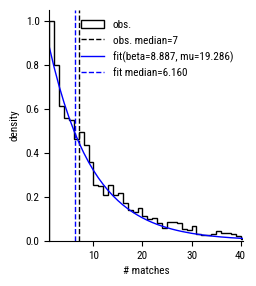

ppm=17.8 tol=0.5


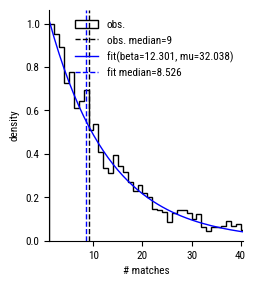

ppm=17.8 tol=0.65


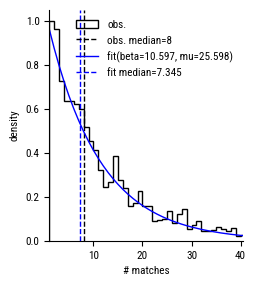

ppm=17.8 tol=0.25


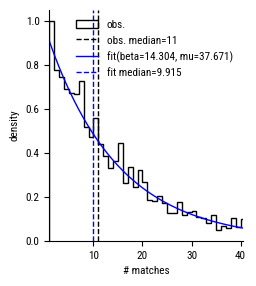

ppm=17.8 tol=0.1


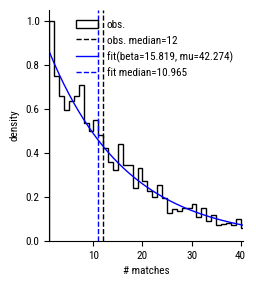

ppm=31.6 tol=0.99


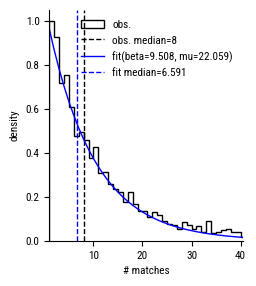

ppm=31.6 tol=0.95


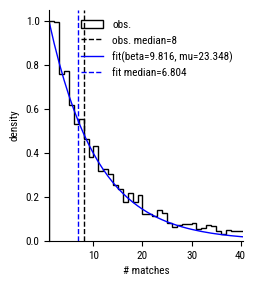

ppm=31.6 tol=0.9


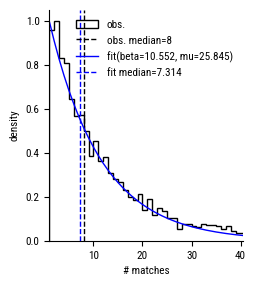

ppm=31.6 tol=0.8


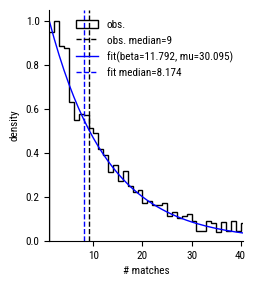

ppm=31.6 tol=0.5


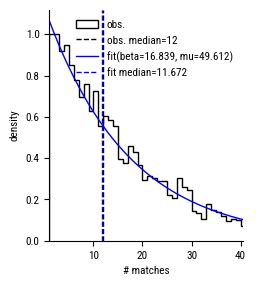

ppm=31.6 tol=0.65


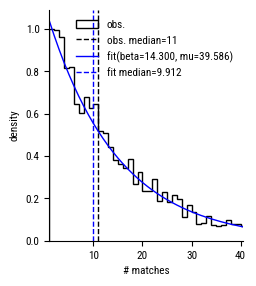

ppm=31.6 tol=0.25


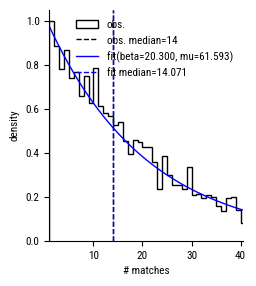

ppm=31.6 tol=0.1


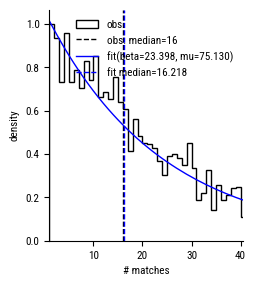

In [7]:
# keep track of fit parameters and summary stats
ppms = []
tols = []
betas = []
mus = []
obs_meds = []
for ppm in MZ_PPMS:
    for tol in MS2_TOLERANCES:
        ppms.append(ppm)
        tols.append(tol)
        print(f"{ppm=} {tol=}")
        fig, ax = plt.subplots(figsize=(2.5, 3))
        bin_max = max(mz_ms2["mz_ms2_probs"][(ppm, tol)]) + 2
        c, x = np.histogram(mz_ms2["mz_ms2_probs"][(ppm, tol)], np.arange(1, bin_max))
        cn = c / max(c)
        ax.hist(mz_ms2["mz_ms2_probs"][(ppm, tol)], bins=np.arange(1, bin_max), color="k", histtype="step", lw=1., 
                weights=[1 / max(c)] * len(mz_ms2["mz_ms2_probs"][(ppm, tol)]), label="obs.") 
        obs_med = np.median(mz_ms2["mz_ms2_probs"][(ppm, tol)])
        ax.axvline(obs_med, ls="--", lw=1., label=f"obs. median={obs_med:.0f}", c="k")
        #print(x[:-1])
        #print(cn)
        (beta, mu), _ = optimize.curve_fit(fexp, x[:-1], cn)
        ax.plot(x[:-1], fexp(x[:-1], beta, mu), 'b-', lw=1., label=f"fit({beta=:.3f}, {mu=:.3f})")
        fit_med = beta * np.log(2.)
        ax.axvline(fit_med, ls="--", lw=1., label=f"fit median={fit_med:.3f}", c="b")
        ax.legend(frameon=False)
        for d in ["top", "right"]:
            ax.spines[d].set_visible(False)
        #ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        ax.set_xlabel("# matches")
        ax.set_ylabel("density")
        ax.set_xlim([1, 40 + 0.5])
        plt.savefig(f"_figures/mz_ms2/{ppm=}_{tol=}_dist_with_fit.png", 
                    dpi=400, bbox_inches="tight")
        plt.show()
        plt.close()
        betas.append(beta)
        mus.append(mu)
        obs_meds.append(obs_med)
fit_meds = [_ * np.log(2) for _ in betas]

In [ ]:
min(fit_meds), max(fit_meds)

In [ ]:
fig, (ax, axcb) = plt.subplots(ncols=2, width_ratios=(9, 1), figsize=(5, 4.5))
mz_bins = MZ_PPMS + [56]
ms2_bins = [1.0] + MS2_TOLERANCES
#levels = [_ for _ in range(2, 27, 2)] #np.arange(2., 26.1, 2.)
levels = [_ + 1 for _ in range(10)] + [15, 20, 25]
tcf = ax.tricontourf(ppms, tols, fit_meds, levels, cmap="binary_r", )#norm="log")
ax.tricontour(ppms, tols, fit_meds, levels, colors="k", linewidths=0.5)
ax.plot(ppms, tols, "wo", ms=5, fillstyle="none", mew=0.5, alpha=0.2)
ax.set_xlabel("m/z tolerance (ppm)")
ax.set_ylabel("MS/MS similarity threshold")
ax.set_xscale("log")
#ax.set_yscale("log")
cb = fig.colorbar(tcf, cax=axcb)
cb.set_ticks(levels)
cb.set_ticklabels(levels)
for l in levels[1:-1]:
    cb.ax.axhline(l, lw=0.75, c="k")
cb.set_label("median # matches (fit)")
plt.savefig(f"_figures/mz_ms2/2D_tolerance_contour.png", 
            dpi=400, bbox_inches="tight")
plt.show()
plt.close()

In [ ]:
(min(fit_meds), max(fit_meds))